# jupyter notebook statistics

## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, SymmetricalLogLocator
import seaborn as sns

mpt.rcParams['figure.dpi'] = 300

sns.set_theme(style='darkgrid', context='notebook', rc={
    'axes.facecolor':  '#EAEAF2',
    'figure.facecolor':'#ffffff',
    'grid.color':      'white',
    'grid.linewidth':  1.0,
})

## helper functions

In [5]:
def ax_plot_hist(
    ax: plt.Axes,
    x: pd.Series,
    iqr_scale: float = 1.5,
    x_log: bool = False,
    y_log: bool = False,
    show_IQR: bool = True,
    show_quartiles: bool = True,
    show_legend: bool = True,
    show_outliers: bool = False,
    title: str = '',
    xlabel: str = '',
    ylabel: str = '',
):
    q1, q2, q3 = x.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - iqr_scale * iqr, q3 + iqr_scale * iqr
    
    q2 += 0.5
    q3 += 1

    ax.hist(x, bins=x.max(), density=False, histtype='bar', color="#7797BC", alpha=0.6, linewidth=0, log=y_log)


    if show_quartiles:
        ax.axvline(q1, color='tab:orange', lw=2, label='Q1', ls='--')
        ax.axvline(q2, color='tab:green', lw=2, label='Median', ls='-')
        ax.axvline(q3, color='tab:red', lw=2, label='Q3', ls='-.')
    if show_IQR:
        ax.axvspan(q1, q3, color='tab:gray', alpha=0.3, label='IQR')
    if show_legend:
        ax.legend()
    if not show_outliers and not x_log:
        ax.set_xlim(max(lower, 0), upper)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    if x_log:
        ax.set_xscale('symlog')
        ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=1e-1, subs=range(2, 10)))
        ax.grid(True, which="major", axis="x", alpha=0.9, lw=0.6, linestyle="-")
        ax.grid(True, which="minor", axis="x", alpha=0.6, lw=0.4, linestyle="-")

    if y_log:
        ax.set_yscale('symlog')
        ax.yaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=1e-1, subs=range(2, 10)))
        ax.grid(True, which="major", axis="y", alpha=0.9, lw=0.6, linestyle="-")
        ax.grid(True, which="minor", axis="y", alpha=0.6, lw=0.4, linestyle="-")

    if not (x_log or y_log):
        ax.grid(True, which='major', axis='y', alpha=0.9, lw=0.6)
    
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    if title:
        ax.set_title(title, fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)


def plot_hist(x: pd.Series, figsize: tuple | None = None, *args, **kwargs):
    fig, ax = plt.subplots(figsize=(figsize or (8, 3)))
    ax_plot_hist(ax, x, *args, **kwargs)
    plt.tight_layout()
    plt.show()


In [6]:
def ax_plot_cell_distribution(
    ax: plt.Axes,
    code_df: pd.DataFrame,
    md_df: pd.DataFrame,
    col_name: str,
    n_bins: int = 100,
    title: str | None = None,
    y_label: str | None = None,
    x_label: str | None = None
):
    # preparing data
    new_col_name = f"is_{col_name}"
    code_df["cell_type"] = "code"
    code_df[new_col_name] = (code_df[col_name] > 0).astype(int)

    md_df["cell_type"] = "text"
    md_df[new_col_name] = 0

    df = pd.concat(
    [
        code_df[["notebook_hash","cell_id","cell_type",new_col_name]],
        md_df[["notebook_hash","cell_id","cell_type",new_col_name]]
    ],
    ignore_index=True
    )
    df = df.sort_values(["notebook_hash", "cell_id"])
    df.head()

    # building distribution
    bins_idx = np.arange(n_bins)
    dist_counts = np.zeros(n_bins, dtype=np.int64)
    nb_counts = 0

    for nb, g in df.groupby("notebook_hash", sort=False):
        vals = g[new_col_name].to_numpy()
        N = len(vals)
        if N == 0:
            continue
        
        k = (bins_idx * N) // n_bins
        dist_counts += vals[k]
        nb_counts += 1

    dist_pct = dist_counts / nb_counts * 100

    # plotting distribution
    top_y = max(dist_pct) * 1.1

    ax.fill_between(bins_idx, 0, dist_pct, color="#7797BC", alpha=0.6)
    ax.fill_between(bins_idx, dist_pct, top_y, color="#d3dae9", alpha=0.6)

    ax.set_xlim(0, n_bins-1)
    ax.set_ylim(0, top_y)

    if title:
        ax.set_title(title, fontweight='bold')
    if y_label:
        ax.set_ylabel(y_label)
    if x_label is None:
        ax.set_xlabel("Section of the Notebook")
    elif x_label:
        ax.set_xlabel(x_label)
    ax.set_xticks([0, n_bins//2, n_bins-1], ["Beginning", "Middle", "End"])


def plot_cell_distribution(
    code_df: pd.DataFrame,
    md_df: pd.DataFrame,
    col_name: str,
    figsize: tuple | None = None,
    *args, **kwargs
):
    fig, ax = plt.subplots(figsize=(figsize or (8, 3)))
    ax_plot_cell_distribution(
        ax=ax,
        code_df=code_df,
        md_df=md_df,
        col_name=col_name,
        *args, **kwargs
    )
    plt.tight_layout()
    plt.show()

## Data Vis

### Overall statistics

#### Per cell

In [ ]:
cell_df = pd.read_csv("data/code_cells_metrics.csv")
cell_df.shape

(3800262, 24)

In [9]:
cell_df.head()

,notebook_hash,cell_id,LOC,BLC,S,P,UDF,NBD,OPRND,OPRAT,...,PO,LMCC,MCC,TMCC,LMIC,MIC,TMIC,V,MSC,TC
0,5057c4a084222da46b138db4597a629e44107d65,0,20,2,17,2,1,1,5,7,...,0,0,0,0,1,2,2,0,0,0
1,5057c4a084222da46b138db4597a629e44107d65,1,9,1,2,0,0,0,2,1,...,0,0,0,0,1,1,1,0,0,0
2,5057c4a084222da46b138db4597a629e44107d65,2,19,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5057c4a084222da46b138db4597a629e44107d65,3,72,13,15,0,0,0,35,11,...,0,0,0,0,1,8,8,0,0,0
4,5057c4a084222da46b138db4597a629e44107d65,5,17,3,3,0,0,0,4,4,...,2,1,2,2,1,1,1,0,0,0


In [4]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800262 entries, 0 to 3800261
Data columns (total 24 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   notebook_hash  object
 1   cell_id        int64 
 2   LOC            int64 
 3   BLC            int64 
 4   S              int64 
 5   P              int64 
 6   UDF            int64 
 7   NBD            int64 
 8   OPRND          int64 
 9   OPRAT          int64 
 10  UOPRND         int64 
 11  UOPRAT         int64 
 12  ID             int64 
 13  I              int64 
 14  PO             int64 
 15  LCO            int64 
 16  CO             int64 
 17  TCO            int64 
 18  LCI            int64 
 19  CI             int64 
 20  TCI            int64 
 21  V              int64 
 22  MSC            int64 
 23  TC             int64 
dtypes: int64(23), object(1)
memory usage: 695.8+ MB


In [8]:
cell_stats_df = cell_df.describe().astype(float).round(2)

In [41]:
cell_stats_df[["LOC","BLC","S","P","UDF","NBD","OPRND","OPRAT","UOPRND","UOPRAT","ID","I"]]

,LOC,BLC,S,P,UDF,NBD,OPRND,OPRAT,UOPRND,UOPRAT,ID,I
count,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00
mean,8.12,1.17,4.70,0.29,0.13,0.26,5.02,3.25,3.28,1.03,6.64,0.40
std,25.23,4.70,13.47,2.14,0.82,0.77,18.01,13.24,7.28,1.54,10.74,1.88
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00
50%,2.00,0.00,2.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,4.00,0.00
75%,7.00,1.00,4.00,0.00,0.00,0.00,4.00,2.00,4.00,1.00,7.00,0.00
max,4632.00,952.00,2783.00,507.00,191.00,18.00,5000.00,4315.00,3421.00,30.00,947.00,406.00


In [117]:
cell_stats_df[["PO","LCO","CO","TCO","LCI","CI","TCI","V","MSC","TC"]]

,PO,LCO,CO,TCO,LCI,CI,TCI,V,MSC,TC
count,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00,3800262.00
mean,1.06,0.50,0.92,1.06,0.40,1.58,1.68,0.07,0.03,0.06
std,3.33,0.72,2.86,3.33,0.57,6.88,7.61,0.44,0.24,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
max,1012.00,95.00,1012.00,1012.00,13.00,1576.00,1766.00,96.00,43.00,90.00


In [138]:
cell_df[cell_df["PO"] > 0]["PO"].count()

np.int64(1539859)

In [139]:
cell_df["PO"].sum()

np.int64(4012542)

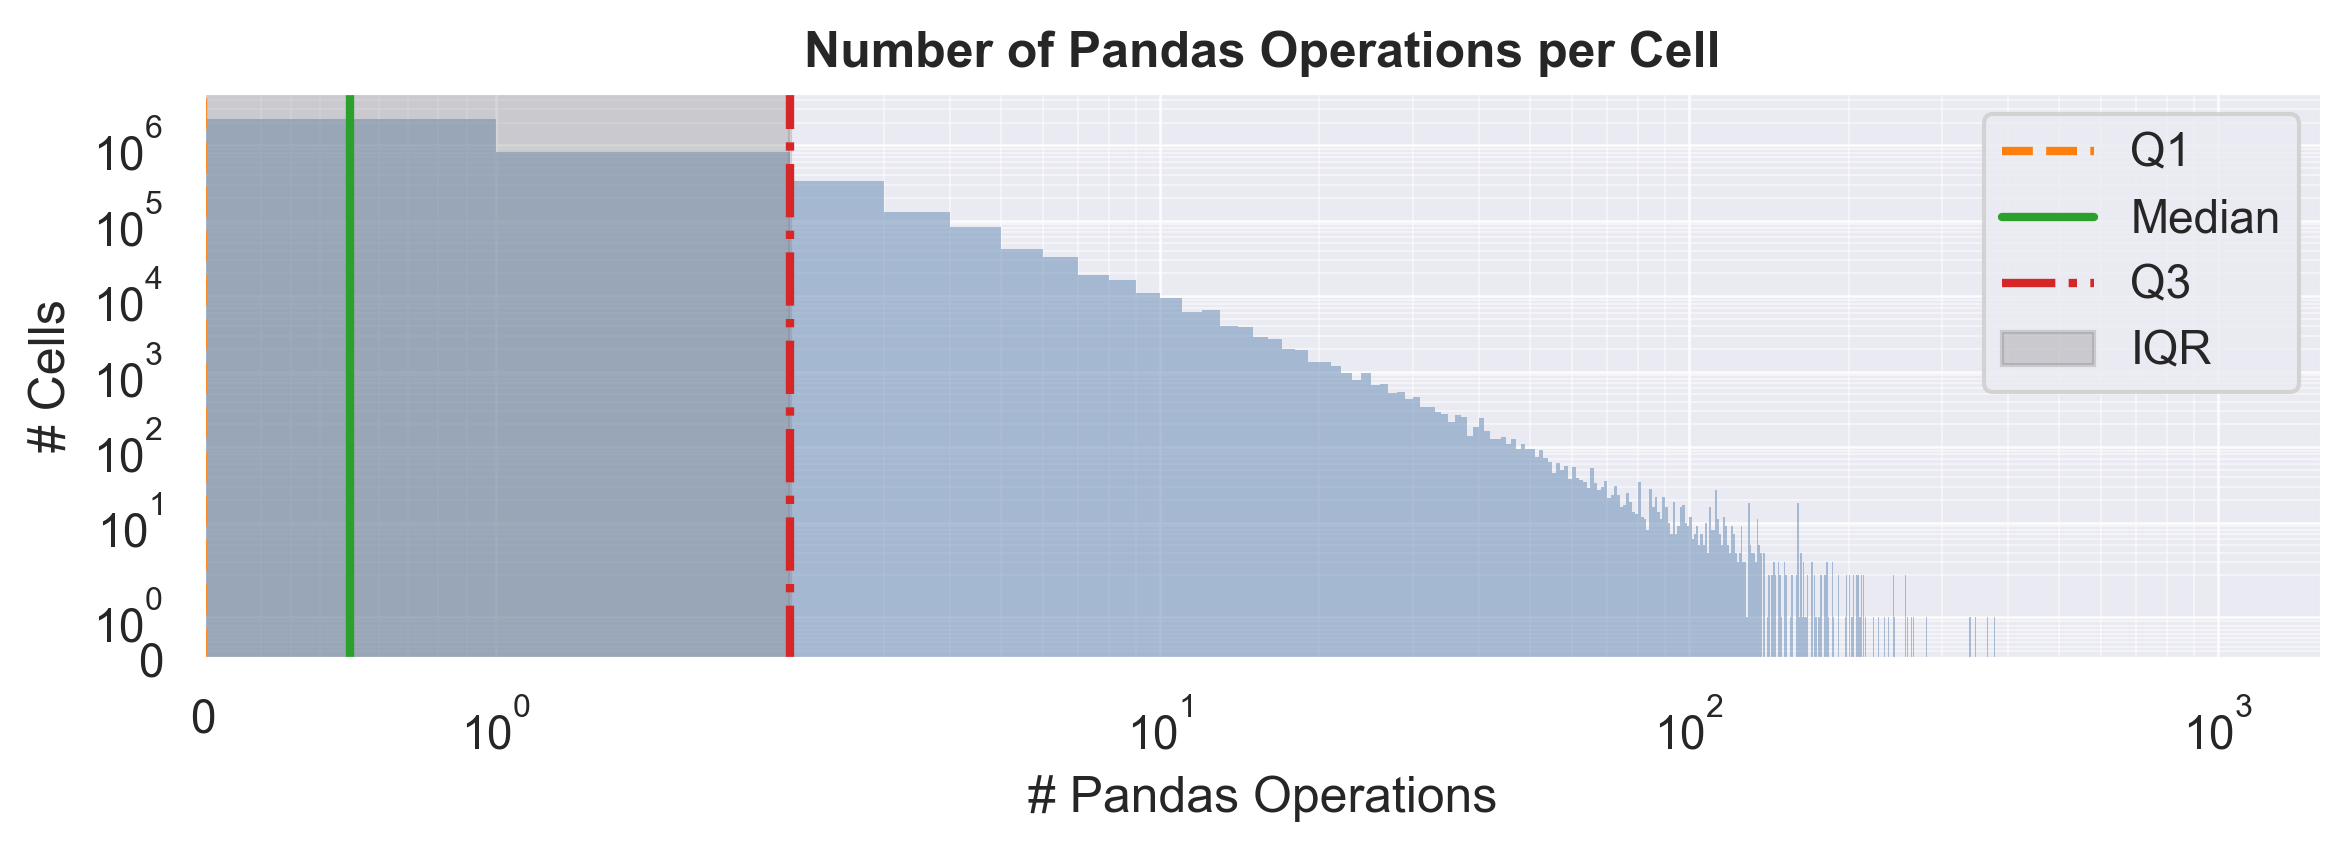

,count,mean,std,min,25%,50%,75%,max
PO,3800262.0,1.06,3.33,0.0,0.0,0.0,1.0,1012.0


In [46]:
plot_hist(
    x=cell_df["PO"],
    figsize=(8, 3),
    title='Number of Pandas Operations per Cell',
    xlabel='# Pandas Operations',
    ylabel='# Cells',
    x_log=True,
    y_log=True
)
cell_stats_df[["PO"]].T

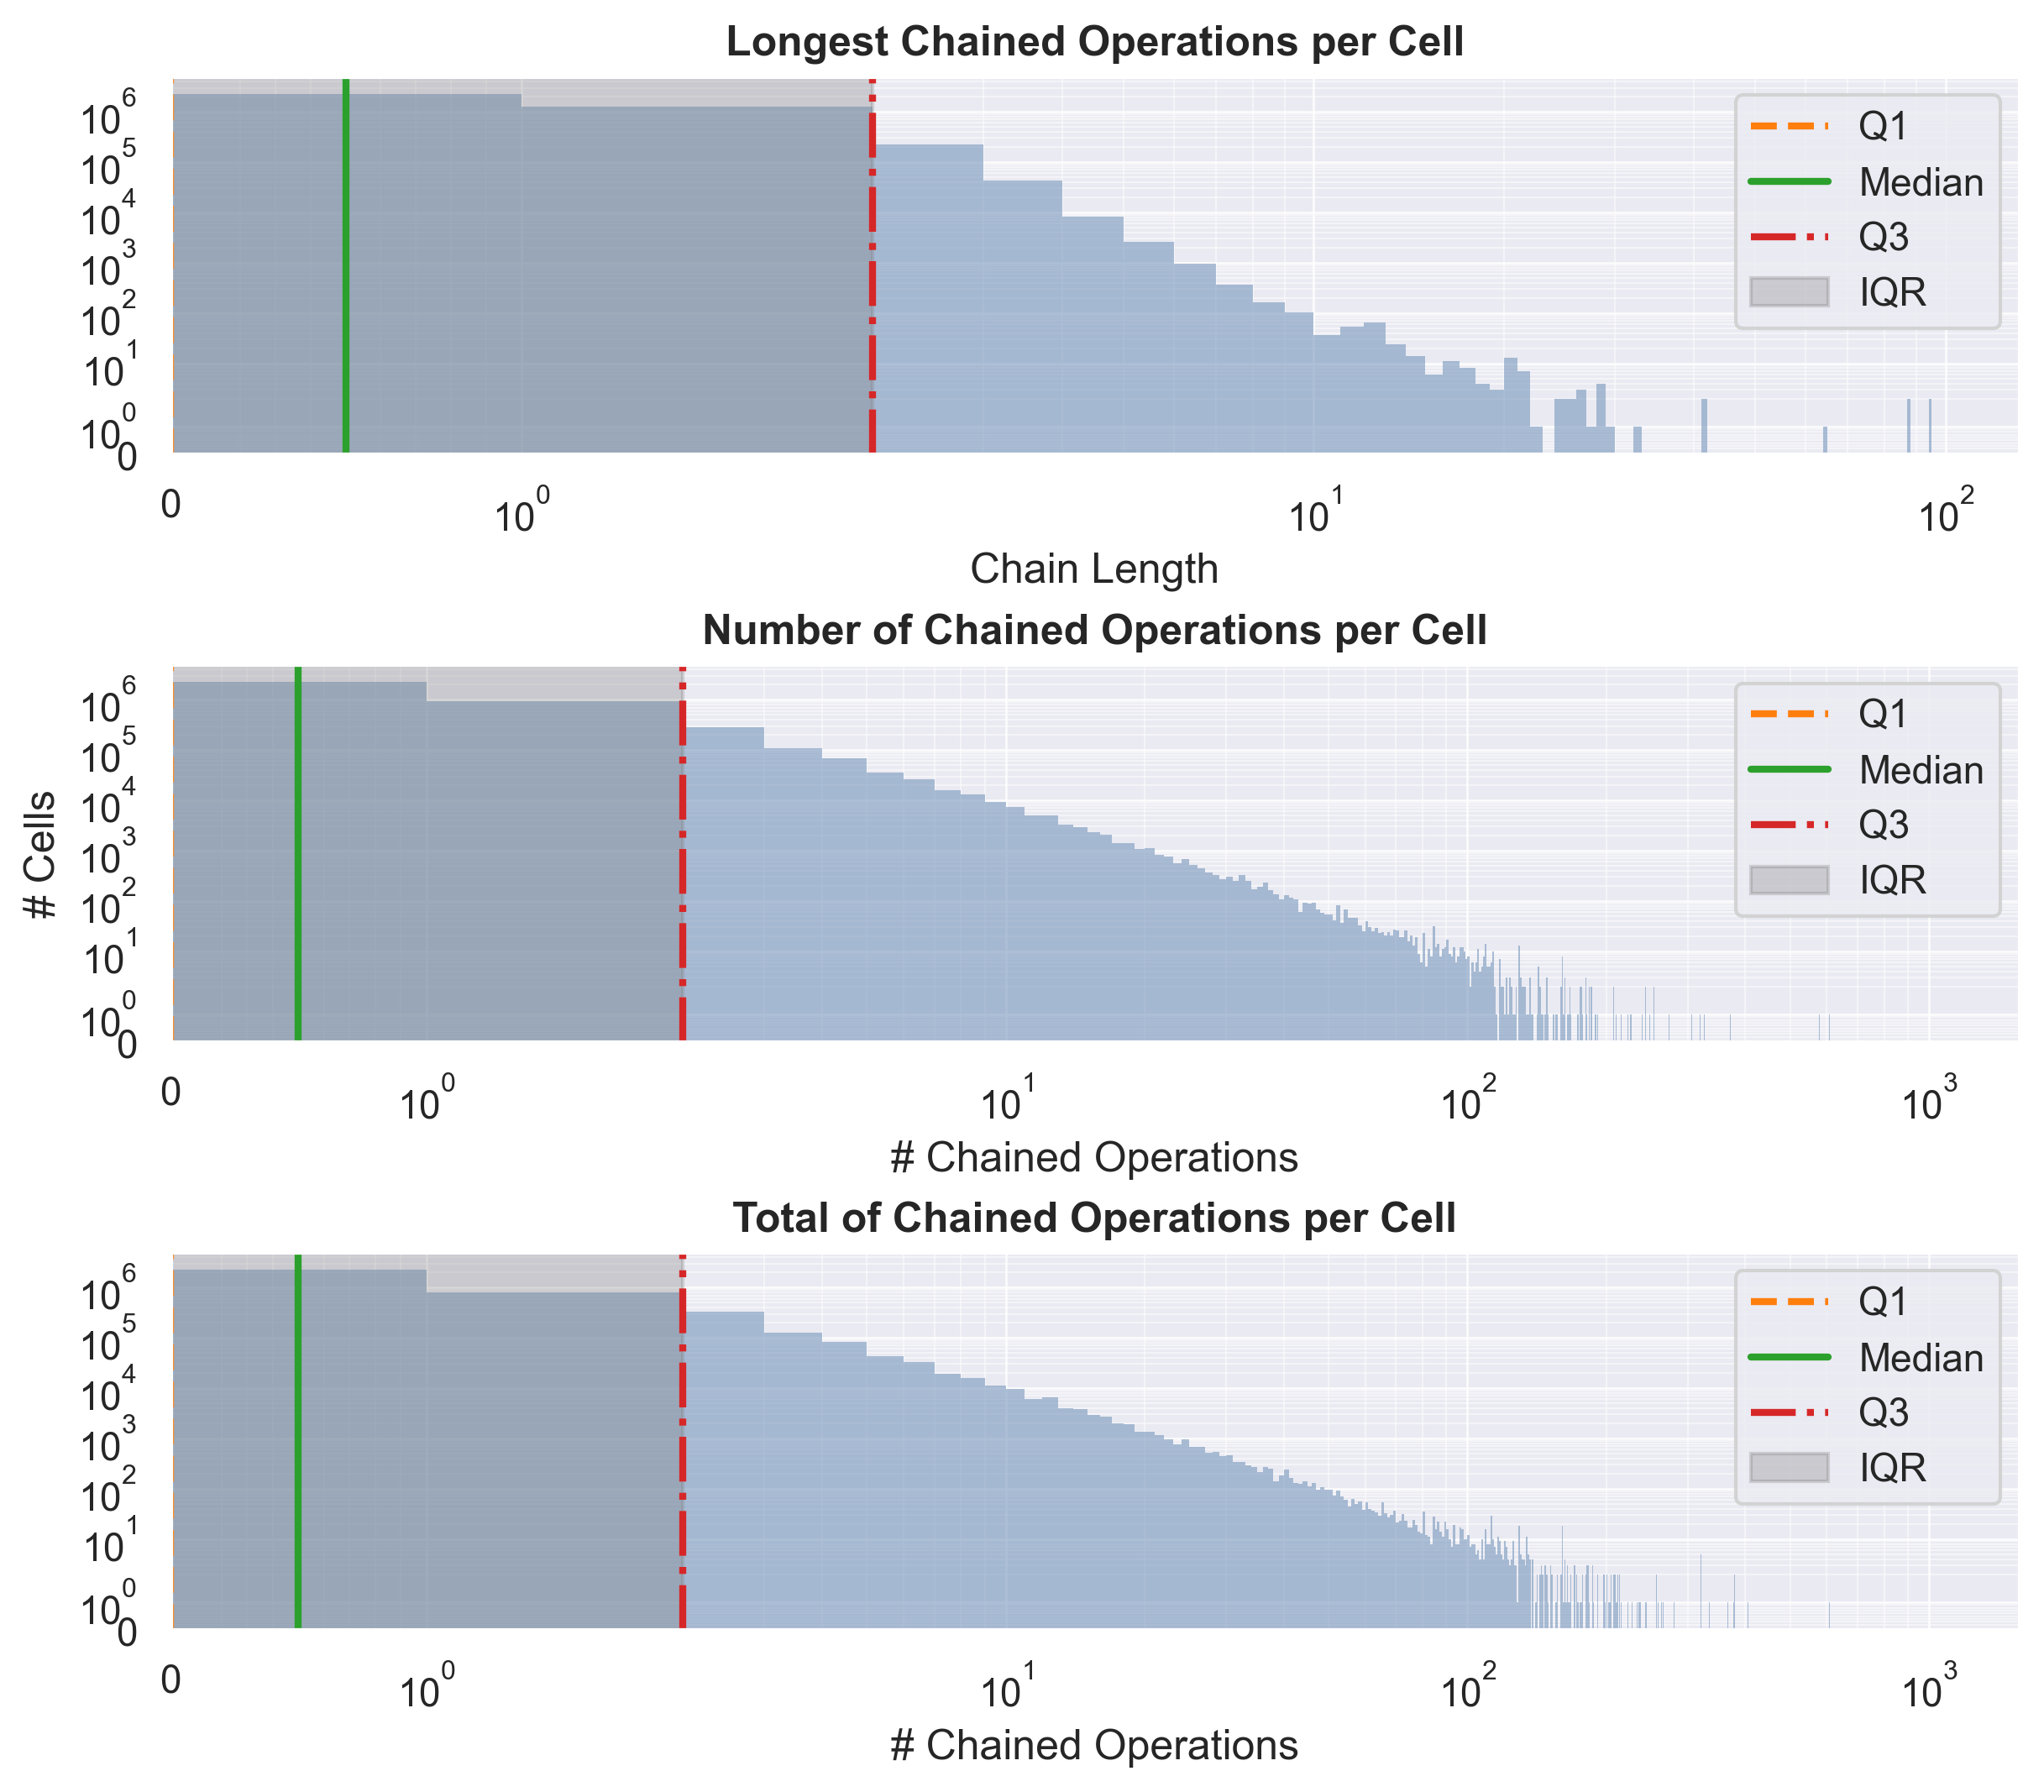

,count,mean,std,min,25%,50%,75%,max
LCO,3800262.0,0.50,0.72,0.0,0.0,0.0,1.0,95.0
CO,3800262.0,0.92,2.86,0.0,0.0,0.0,1.0,1012.0
TCO,3800262.0,1.06,3.33,0.0,0.0,0.0,1.0,1012.0


In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=cell_df["LCO"],
    iqr_scale=10,
    title='Longest Chained Operations per Cell',
    xlabel='Chain Length',
    # ylabel='# Cells',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=cell_df["CO"],
    title='Number of Chained Operations per Cell',
    xlabel='# Chained Operations',
    ylabel='# Cells',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=cell_df["TCO"],
    title='Total of Chained Operations per Cell',
    xlabel='# Chained Operations',
    # ylabel='# Cells',
    x_log=True,
    y_log=True
)

plt.show()
cell_stats_df[["LCO","CO","TCO"]].T


In [194]:
tmp = cell_df[cell_df["CO"] > 0]
avg = tmp["TCO"] / tmp["CO"]
tmp.shape[0], avg.sum() / avg.shape[0]

(1539859, np.float64(1.1468874279890127))

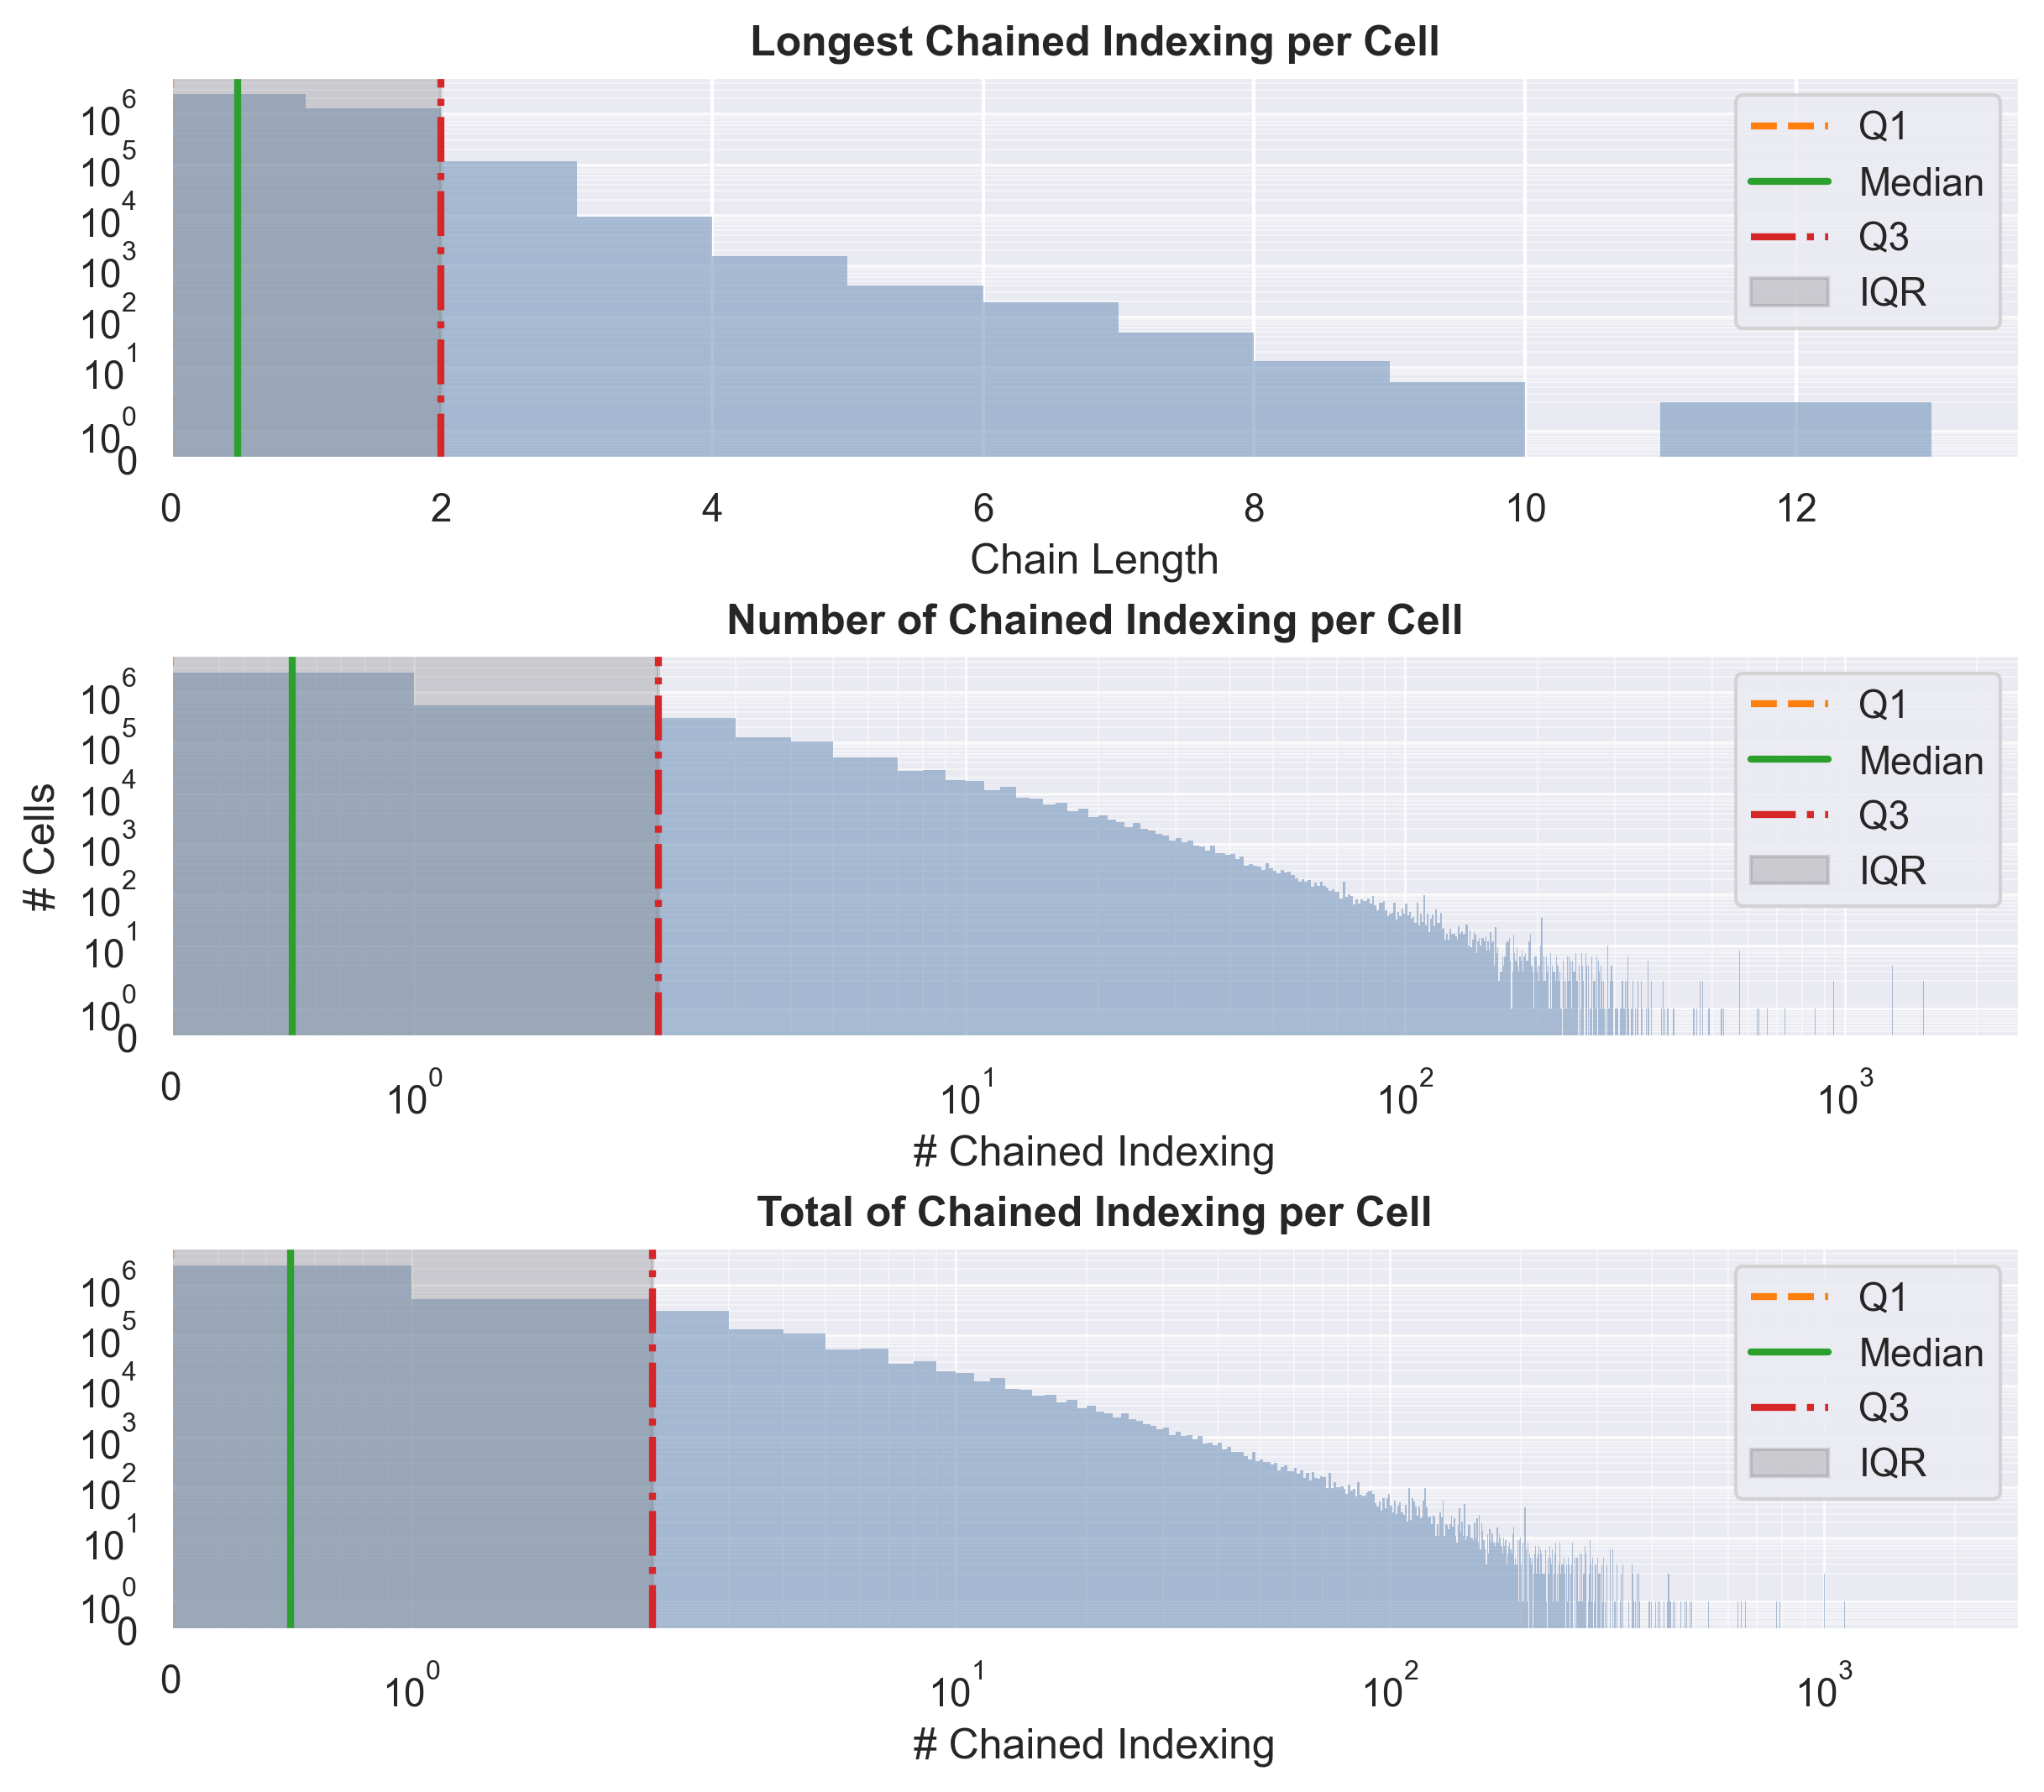

,count,mean,std,min,25%,50%,75%,max
LCI,3800262.0,0.40,0.57,0.0,0.0,0.0,1.0,13.0
CI,3800262.0,1.58,6.88,0.0,0.0,0.0,1.0,1576.0
TCI,3800262.0,1.68,7.61,0.0,0.0,0.0,1.0,1766.0


In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=cell_df["LCI"],
    show_outliers=True,
    title='Longest Chained Indexing per Cell',
    xlabel='Chain Length',
    # ylabel='# Cells',
    # x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=cell_df["CI"],
    title='Number of Chained Indexing per Cell',
    xlabel='# Chained Indexing',
    ylabel='# Cells',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=cell_df["TCI"],
    title='Total of Chained Indexing per Cell',
    xlabel='# Chained Indexing',
    # ylabel='# Cells',
    x_log=True,
    y_log=True
)

plt.show()
cell_stats_df[["LCI","CI","TCI"]].T

In [193]:
tmp = cell_df[cell_df["CI"] > 0]
avg = tmp["TCI"] / tmp["CI"]
tmp.shape[0], avg.sum() / avg.shape[0]

(1384353, np.float64(1.0485915611831986))

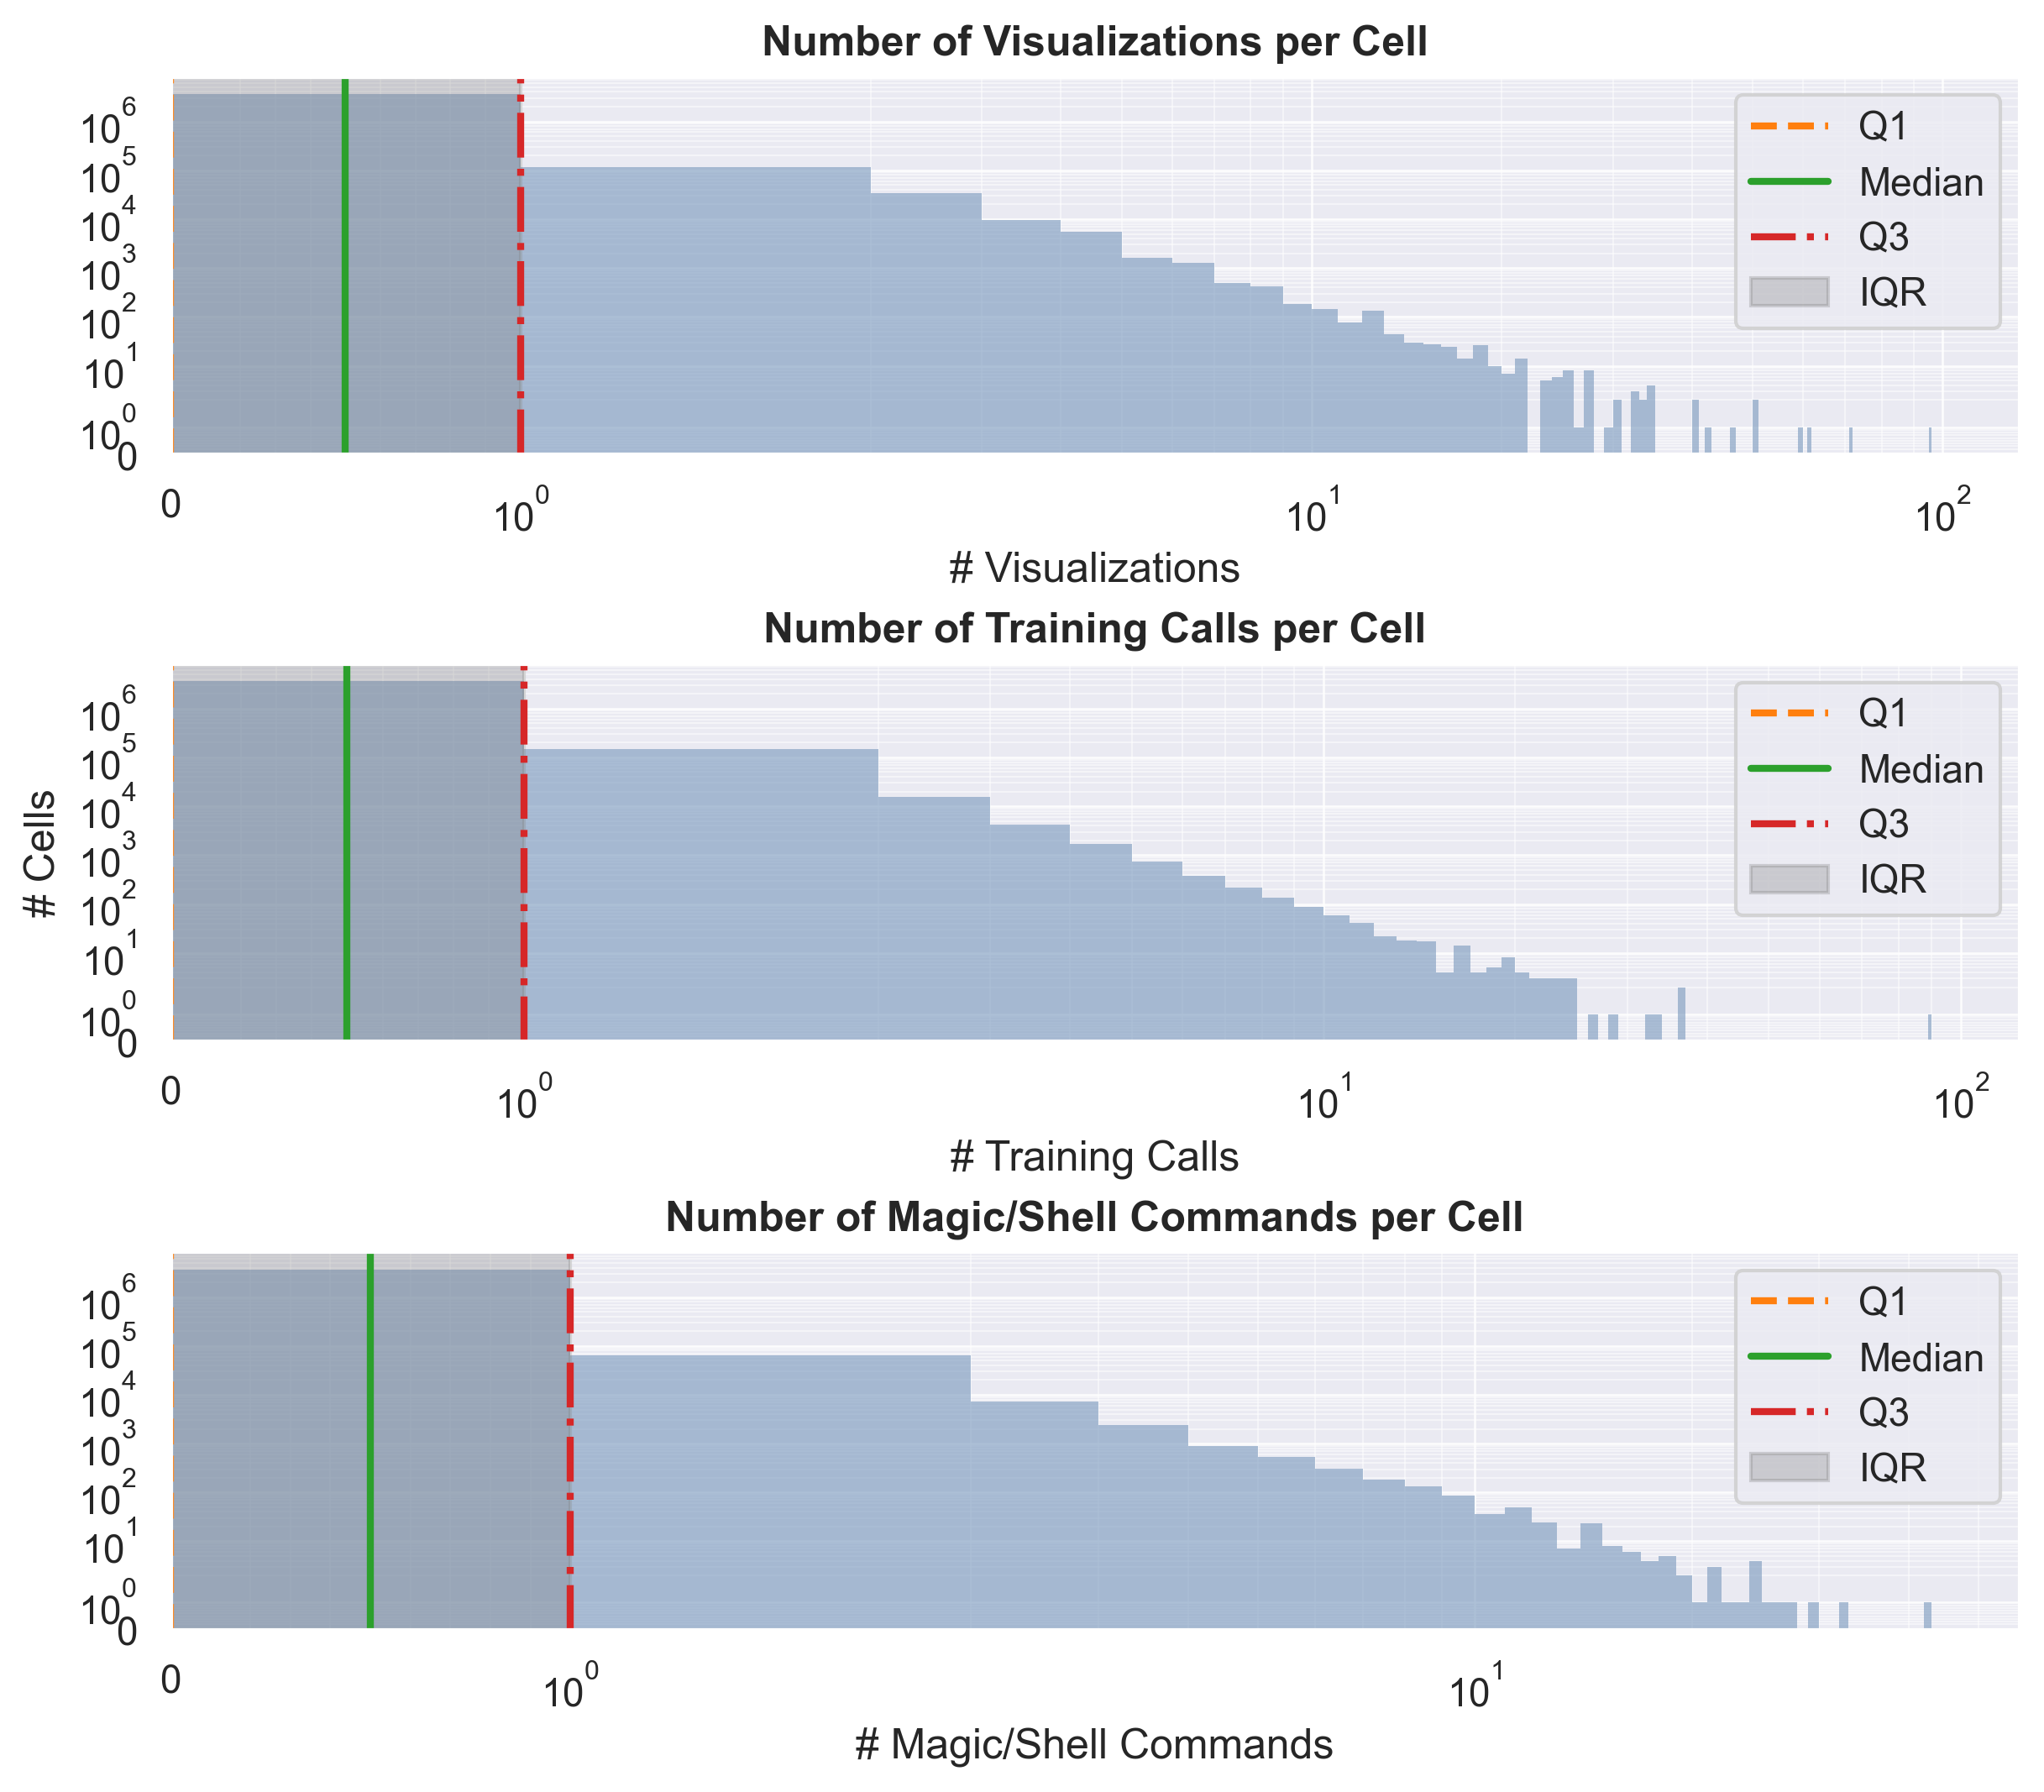

,count,mean,std,min,25%,50%,75%,max
V,3800262.0,0.07,0.44,0.0,0.0,0.0,0.0,96.0
TC,3800262.0,0.06,0.31,0.0,0.0,0.0,0.0,90.0
MSC,3800262.0,0.03,0.24,0.0,0.0,0.0,0.0,43.0


In [51]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=cell_df["V"],
    show_outliers=True,
    title='Number of Visualizations per Cell',
    xlabel='# Visualizations',
    # ylabel='# Cells',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=cell_df["TC"],
    show_outliers=True,
    title='Number of Training Calls per Cell',
    xlabel='# Training Calls',
    ylabel='# Cells',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=cell_df["MSC"],
    show_outliers=True,
    title='Number of Magic/Shell Commands per Cell',
    xlabel='# Magic/Shell Commands',
    # ylabel='# Cells',
    x_log=True,
    y_log=True
)

plt.show()
cell_stats_df[["V","TC","MSC"]].T

#### Per notebook

In [ ]:
cell_df = pd.read_csv("data/code_cells_metrics.csv")

In [12]:
nb_df = cell_df.groupby("notebook_hash").agg(
    n_cells=("cell_id", "count"),
    LOC=("LOC", "sum"),
    BLC=("BLC", "sum"),
    S=("S", "sum"),
    P=("P", "sum"),
    UDF=("UDF", "sum"),
    NBD=("NBD", "max"),
    OPRND=("OPRND", "sum"),
    OPRAT=("OPRAT", "sum"),
    UOPRND=("UOPRND", "max"),  # 
    UOPRAT=("UOPRAT", "max"),  # 
    ID=("ID", "sum"),
    I=("I", "sum"),
    PO=("PO", "sum"),
    LCO=("LCO", "max"),
    CO=("CO", "sum"),
    TCO=("TCO", "sum"),
    LCI=("LCI", "max"),
    CI=("CI", "sum"),
    TCI=("TCI", "sum"),
    V=("V", "sum"),
    MSC=("MSC", "sum"),
    TC=("TC", "sum")
)

nb_df.head()

,n_cells,LOC,BLC,S,P,UDF,NBD,OPRND,OPRAT,UOPRND,...,PO,LCO,CO,TCO,LCI,CI,TCI,V,MSC,TC
notebook_hash,,,,,,,,,,,,,,,,,,,,,
00007f1681b73a5c38ff28da0e2994b4d13e57fa,6,76,11,50,2,2,4,37,29,13,...,8,1,8,8,1,5,5,0,0,0
000091fcb56278cb8c302b75b51b52805d439dc7,21,182,19,84,8,4,3,69,40,13,...,4,1,4,4,1,6,6,0,2,1
0000c46de7aa028b818a46de53faf8a3ee4af253,21,285,45,159,9,7,4,186,81,15,...,14,2,13,14,3,68,74,0,0,0
00038c2e984da385a5a49d881e74e7fdc7eb3d00,28,51,0,51,0,0,0,91,25,7,...,43,2,35,43,2,26,27,0,0,0
0004ea206f31a0f1cb2f478a4c9c608ed09aaa92,9,83,15,41,8,2,2,49,23,21,...,13,3,9,13,2,7,9,0,0,0


In [13]:
nb_stats_df = nb_df.describe().astype(float).round(2)

In [14]:
nb_stats_df[["LOC","BLC","S","P","UDF","NBD","OPRND","OPRAT","UOPRND","UOPRAT","ID","I"]]

,LOC,BLC,S,P,UDF,NBD,OPRND,OPRAT,UOPRND,UOPRAT,ID,I
count,139622.00,139622.00,139622.00,139622.00,139622.00,139622.0,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00
mean,220.92,31.80,127.83,7.83,3.50,2.0,136.51,88.44,18.51,4.65,180.77,10.76
std,286.82,51.63,151.06,19.55,7.61,1.7,195.11,136.40,24.56,3.23,176.87,10.88
min,3.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
25%,74.00,5.00,49.00,0.00,0.00,1.0,45.00,24.00,7.00,2.00,77.00,4.00
50%,139.00,17.00,86.00,1.00,1.00,2.0,85.00,50.00,13.00,4.00,133.00,8.00
75%,260.00,38.00,152.00,7.00,4.00,3.0,158.00,102.00,22.00,6.00,225.00,14.00
max,6764.00,1229.00,3909.00,1254.00,325.00,18.0,9615.00,6176.00,3421.00,30.00,5207.00,608.00


In [15]:
nb_stats_df[["PO","LCO","CO","TCO","LCI","CI","TCI","V","MSC","TC"]]

,PO,LCO,CO,TCO,LCI,CI,TCI,V,MSC,TC
count,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00,139622.00
mean,28.74,1.90,25.13,28.73,1.41,43.00,45.79,1.94,0.72,1.51
std,39.91,1.19,33.42,39.90,0.66,72.82,80.29,4.61,2.54,3.16
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,1.00,8.00,9.00,1.00,11.00,12.00,0.00,0.00,0.00
50%,18.00,2.00,16.00,18.00,1.00,24.00,25.00,0.00,0.00,0.00
75%,35.00,2.00,30.00,35.00,2.00,49.00,51.00,2.00,1.00,2.00
max,2918.00,95.00,2112.00,2918.00,13.00,4169.00,5129.00,234.00,261.00,91.00


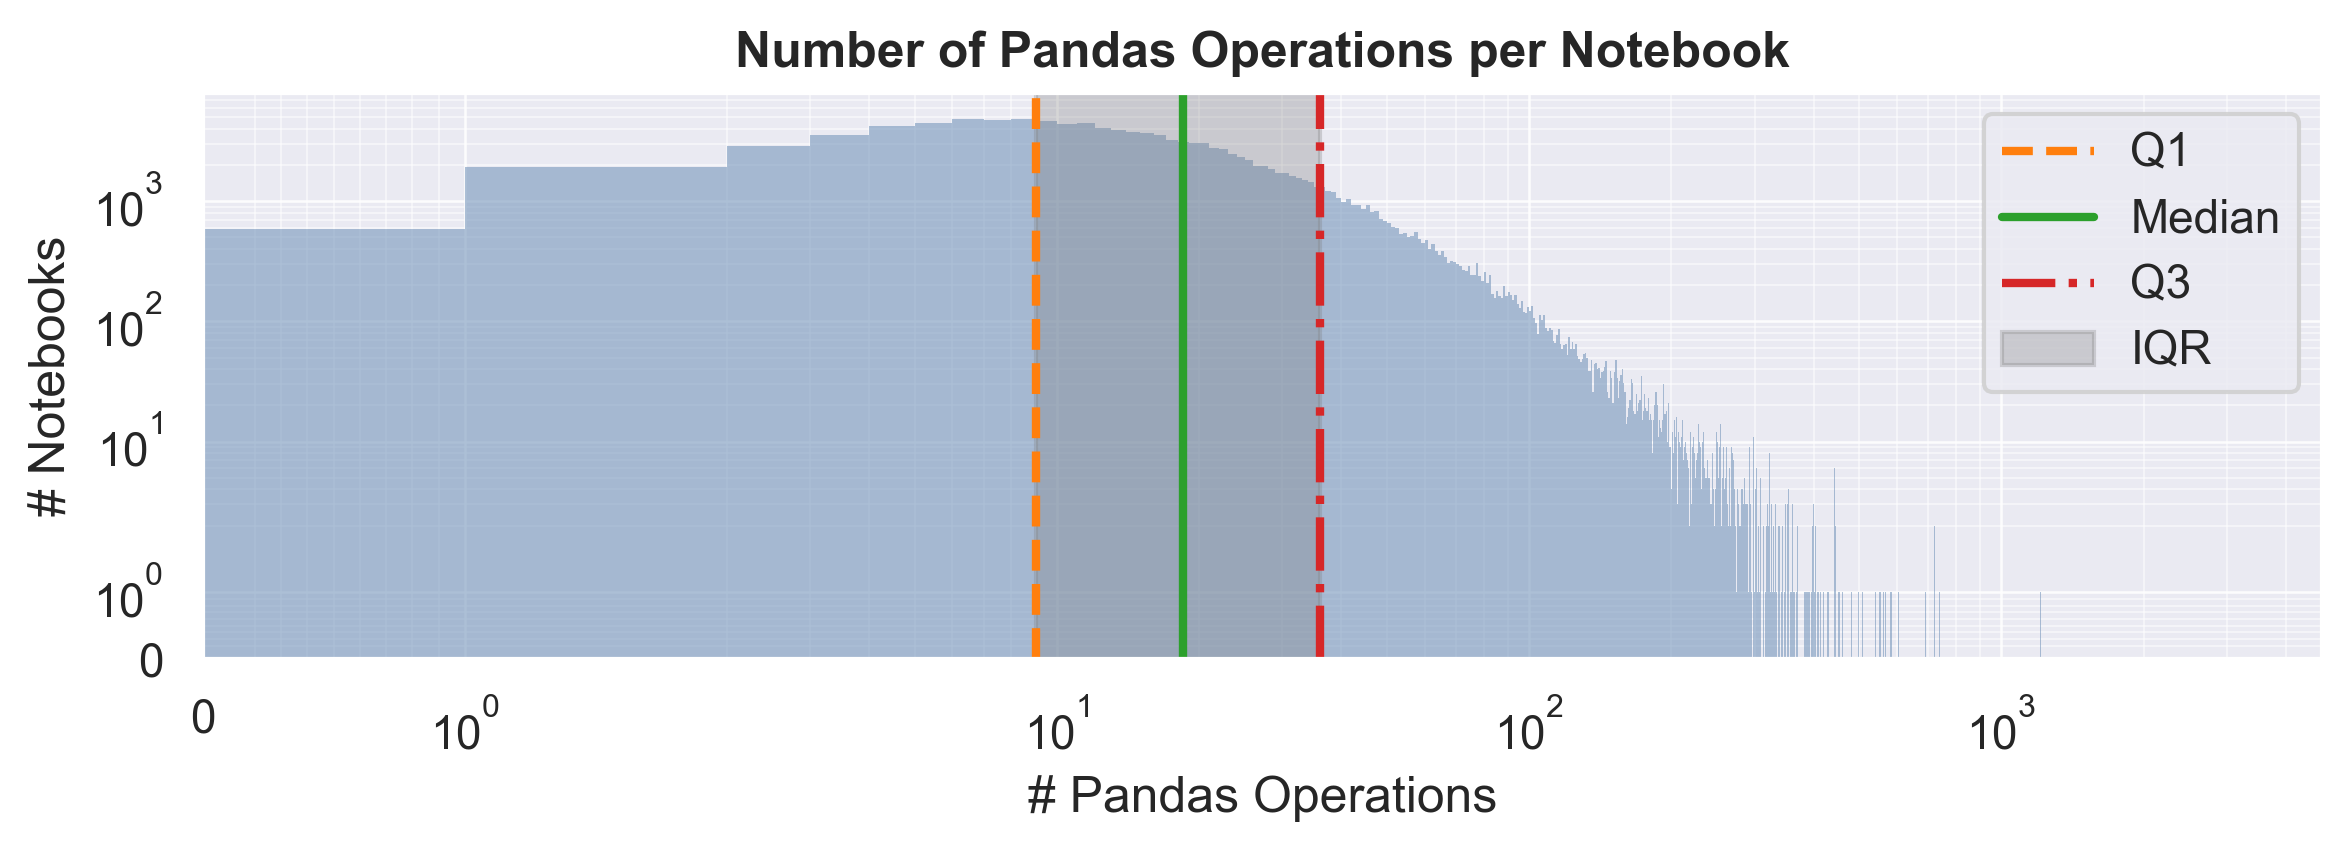

,count,mean,std,min,25%,50%,75%,max
PO,139622.0,28.74,39.91,0.0,9.0,18.0,35.0,2918.0


In [ ]:
plot_hist(
    x=nb_df["PO"],
    figsize=(8, 3),
    title='Number of Pandas Operations per Notebook',
    xlabel='# Pandas Operations',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
nb_stats_df[["PO"]].T

In [65]:
nb_df[nb_df["PO"] > 0].shape, nb_df.shape

((139032, 23), (139622, 23))

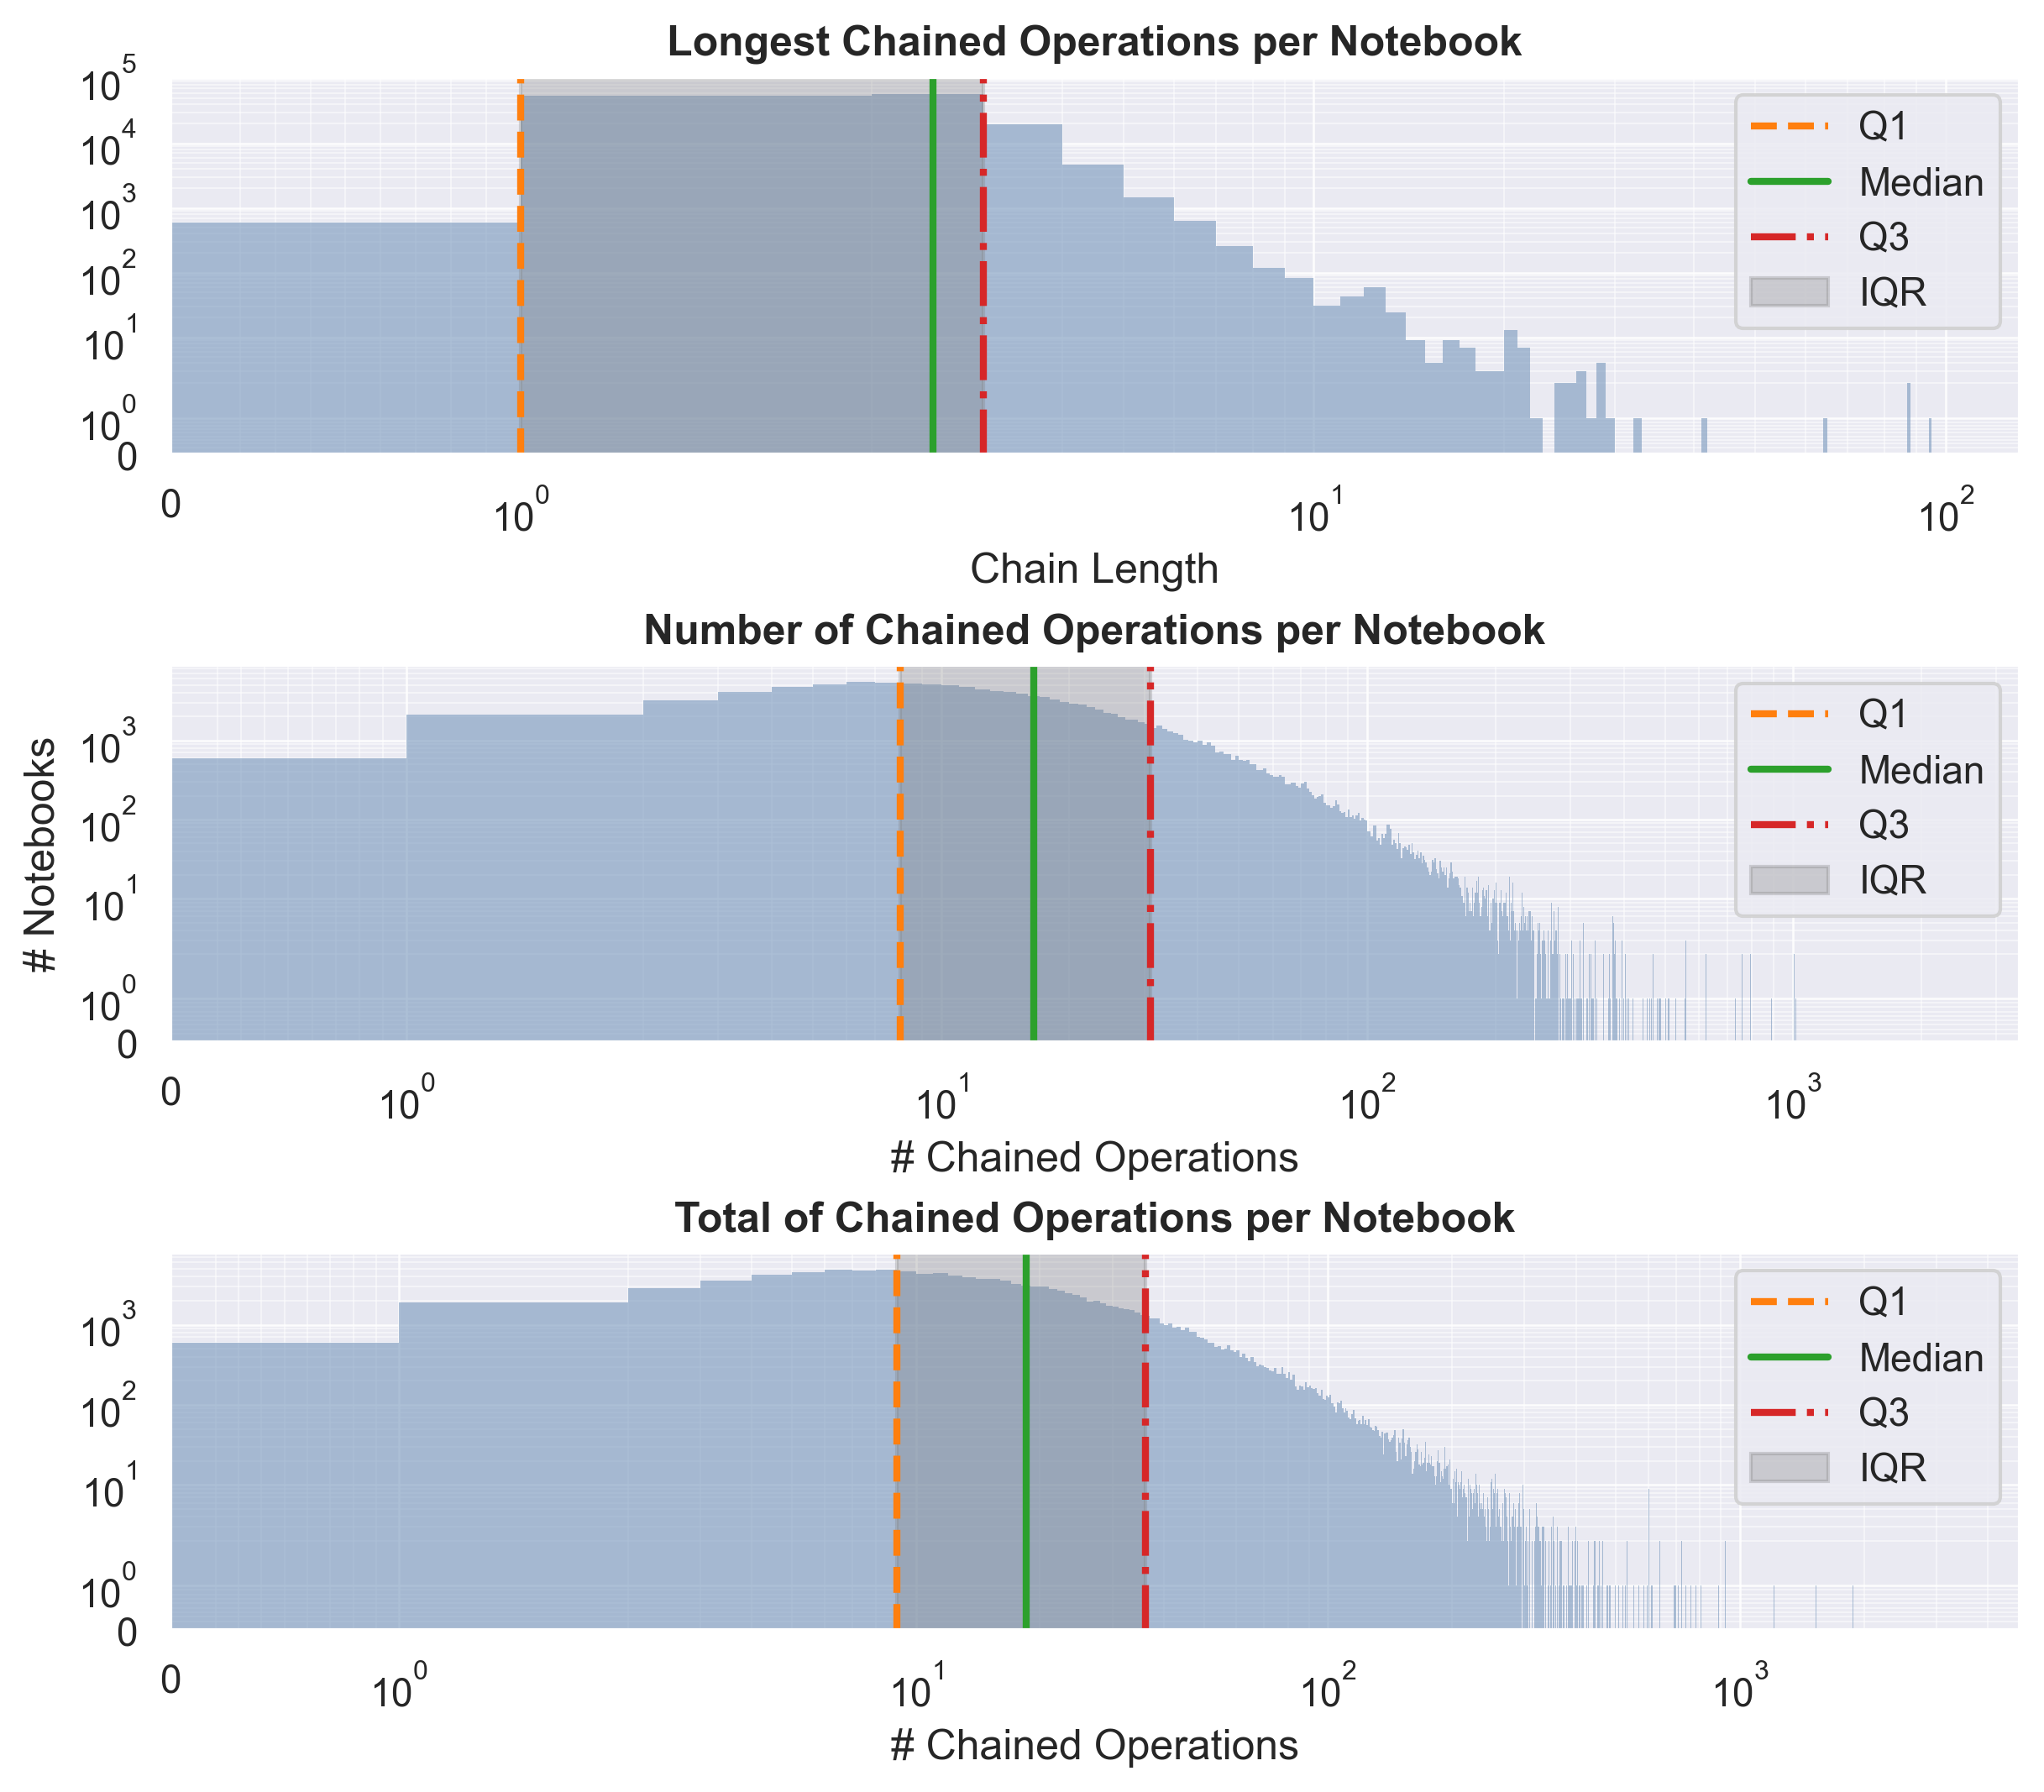

,count,mean,std,min,25%,50%,75%,max
LCO,139622.0,1.90,1.19,0.0,1.0,2.0,2.0,95.0
CO,139622.0,25.13,33.42,0.0,8.0,16.0,30.0,2112.0
TCO,139622.0,28.73,39.90,0.0,9.0,18.0,35.0,2918.0


In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=nb_df["LCO"],
    iqr_scale=10,
    title='Longest Chained Operations per Notebook',
    xlabel='Chain Length',
    # ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=nb_df["CO"],
    title='Number of Chained Operations per Notebook',
    xlabel='# Chained Operations',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=nb_df["TCO"],
    title='Total of Chained Operations per Notebook',
    xlabel='# Chained Operations',
    # ylabel='# Notebooks',
    x_log=True,
    y_log=True
)

plt.show()
nb_stats_df[["LCO","CO","TCO"]].T


In [79]:
tmp = nb_df[nb_df["CO"] > 0]
avg = tmp["TCO"] / tmp["CO"]
tmp.shape[0], avg.sum() / avg.shape[0]

(139032, np.float64(1.1305588373716575))

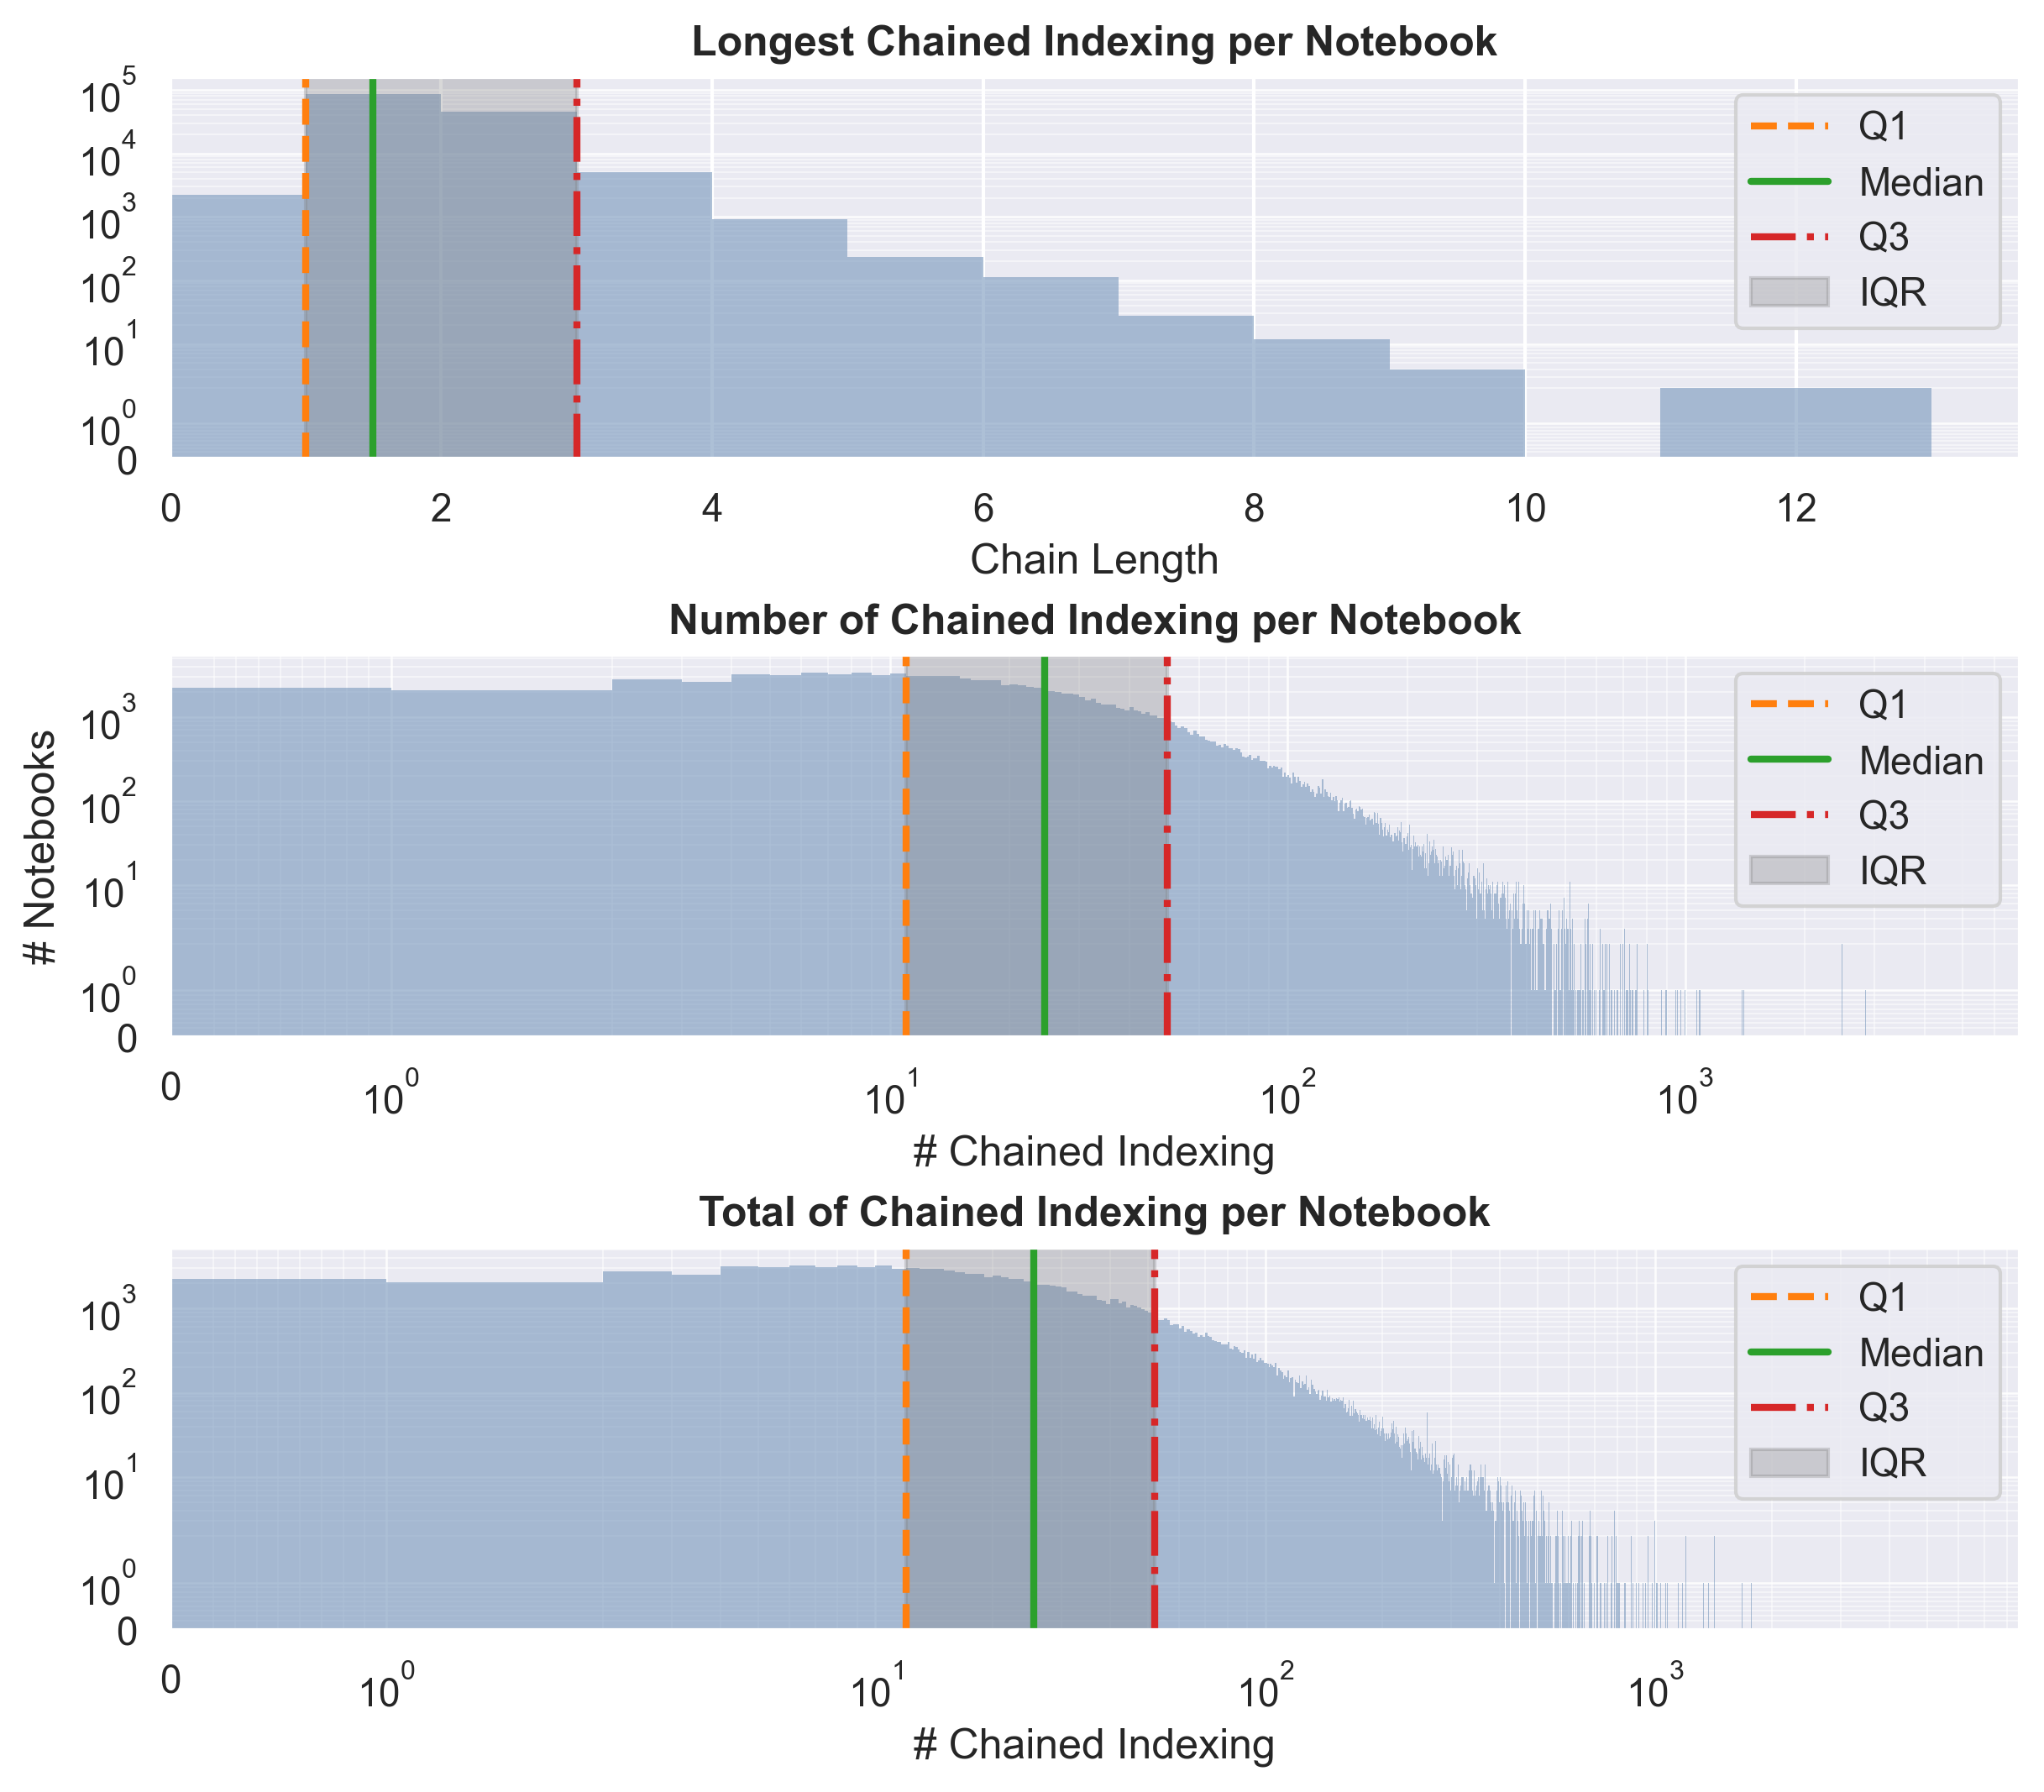

,count,mean,std,min,25%,50%,75%,max
LCI,139622.0,1.41,0.66,0.0,1.0,1.0,2.0,13.0
CI,139622.0,43.00,72.82,0.0,11.0,24.0,49.0,4169.0
TCI,139622.0,45.79,80.29,0.0,12.0,25.0,51.0,5129.0


In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=nb_df["LCI"],
    show_outliers=True,
    title='Longest Chained Indexing per Notebook',
    xlabel='Chain Length',
    # ylabel='# Notebooks',
    # x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=nb_df["CI"],
    title='Number of Chained Indexing per Notebook',
    xlabel='# Chained Indexing',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=nb_df["TCI"],
    title='Total of Chained Indexing per Notebook',
    xlabel='# Chained Indexing',
    # ylabel='# Notebooks',
    x_log=True,
    y_log=True
)

plt.show()
nb_stats_df[["LCI","CI","TCI"]].T

In [ ]:
tmp = nb_df[nb_df["CI"] > 0]
avg = tmp["TCI"] / tmp["CI"]
tmp.shape[0], avg.sum() / avg.shape[0]

(137364, np.float64(1.0482373519934411))

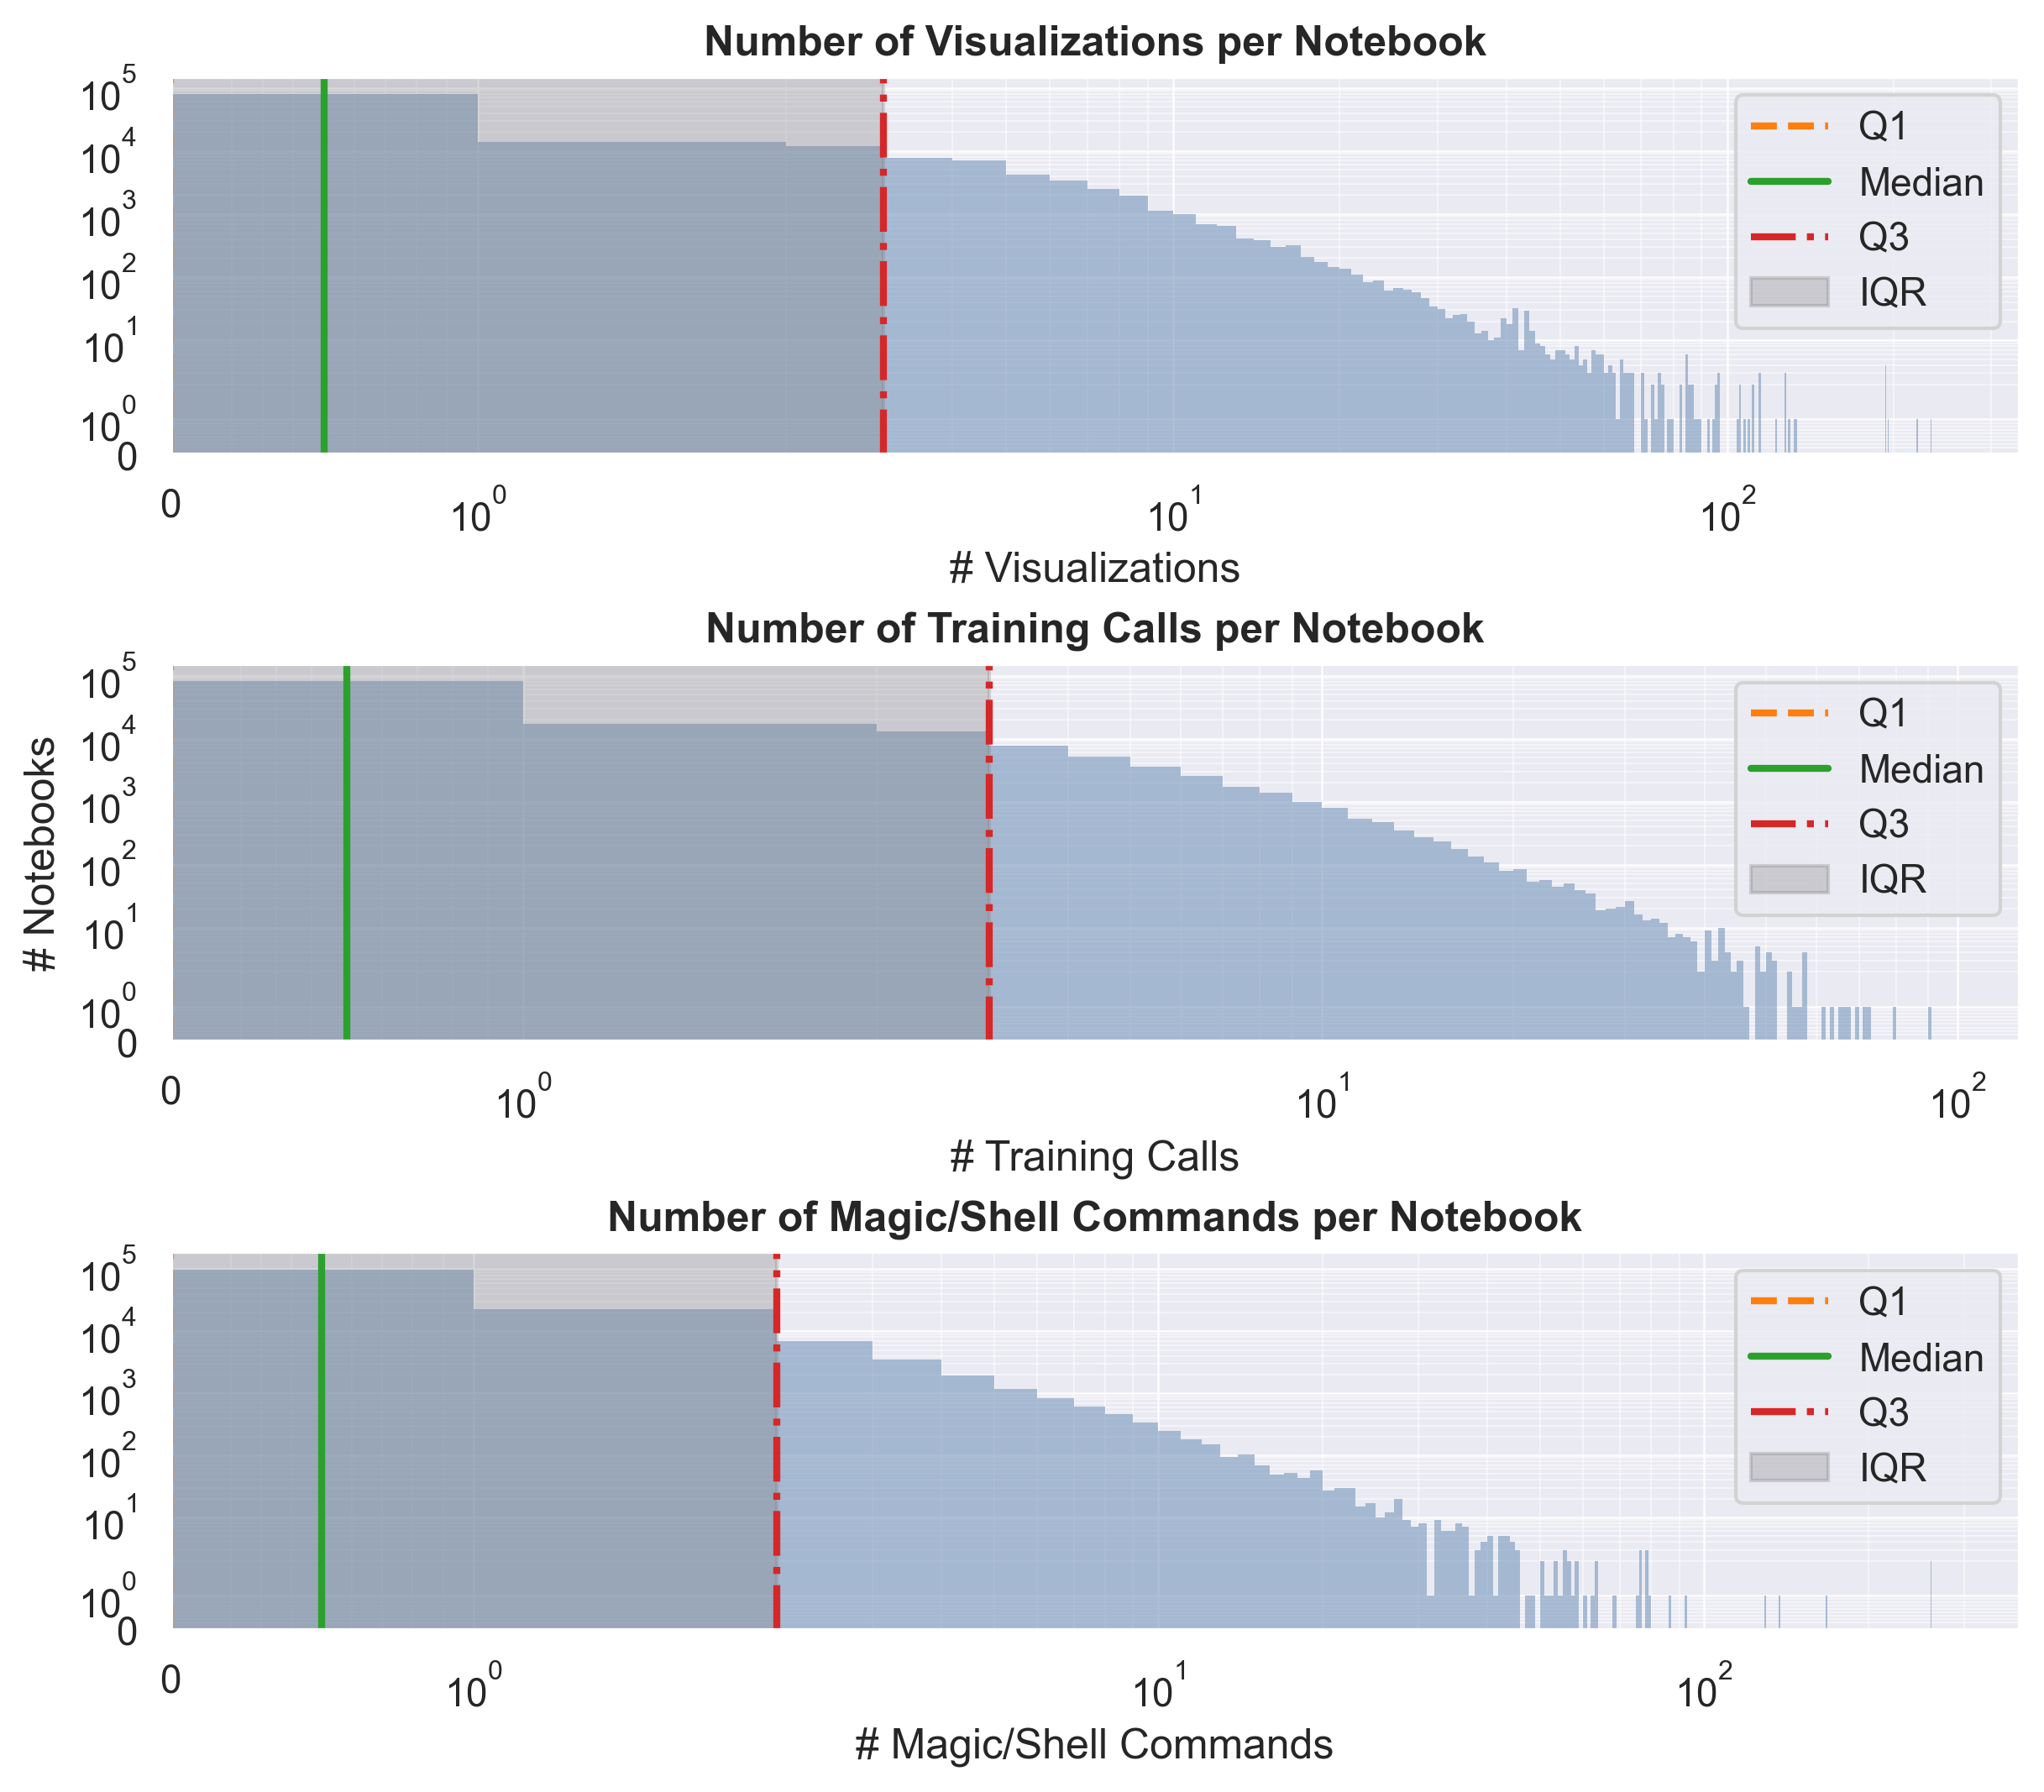

,count,mean,std,min,25%,50%,75%,max
V,139622.0,1.94,4.61,0.0,0.0,0.0,2.0,234.0
TC,139622.0,1.51,3.16,0.0,0.0,0.0,2.0,91.0
MSC,139622.0,0.72,2.54,0.0,0.0,0.0,1.0,261.0


In [56]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=nb_df["V"],
    show_outliers=True,
    title='Number of Visualizations per Notebook',
    xlabel='# Visualizations',
    # ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=nb_df["TC"],
    show_outliers=True,
    title='Number of Training Calls per Notebook',
    xlabel='# Training Calls',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[2],
    x=nb_df["MSC"],
    show_outliers=True,
    title='Number of Magic/Shell Commands per Notebook',
    xlabel='# Magic/Shell Commands',
    # ylabel='# Notebooks',
    x_log=True,
    y_log=True
)

plt.show()
nb_stats_df[["V","TC","MSC"]].T

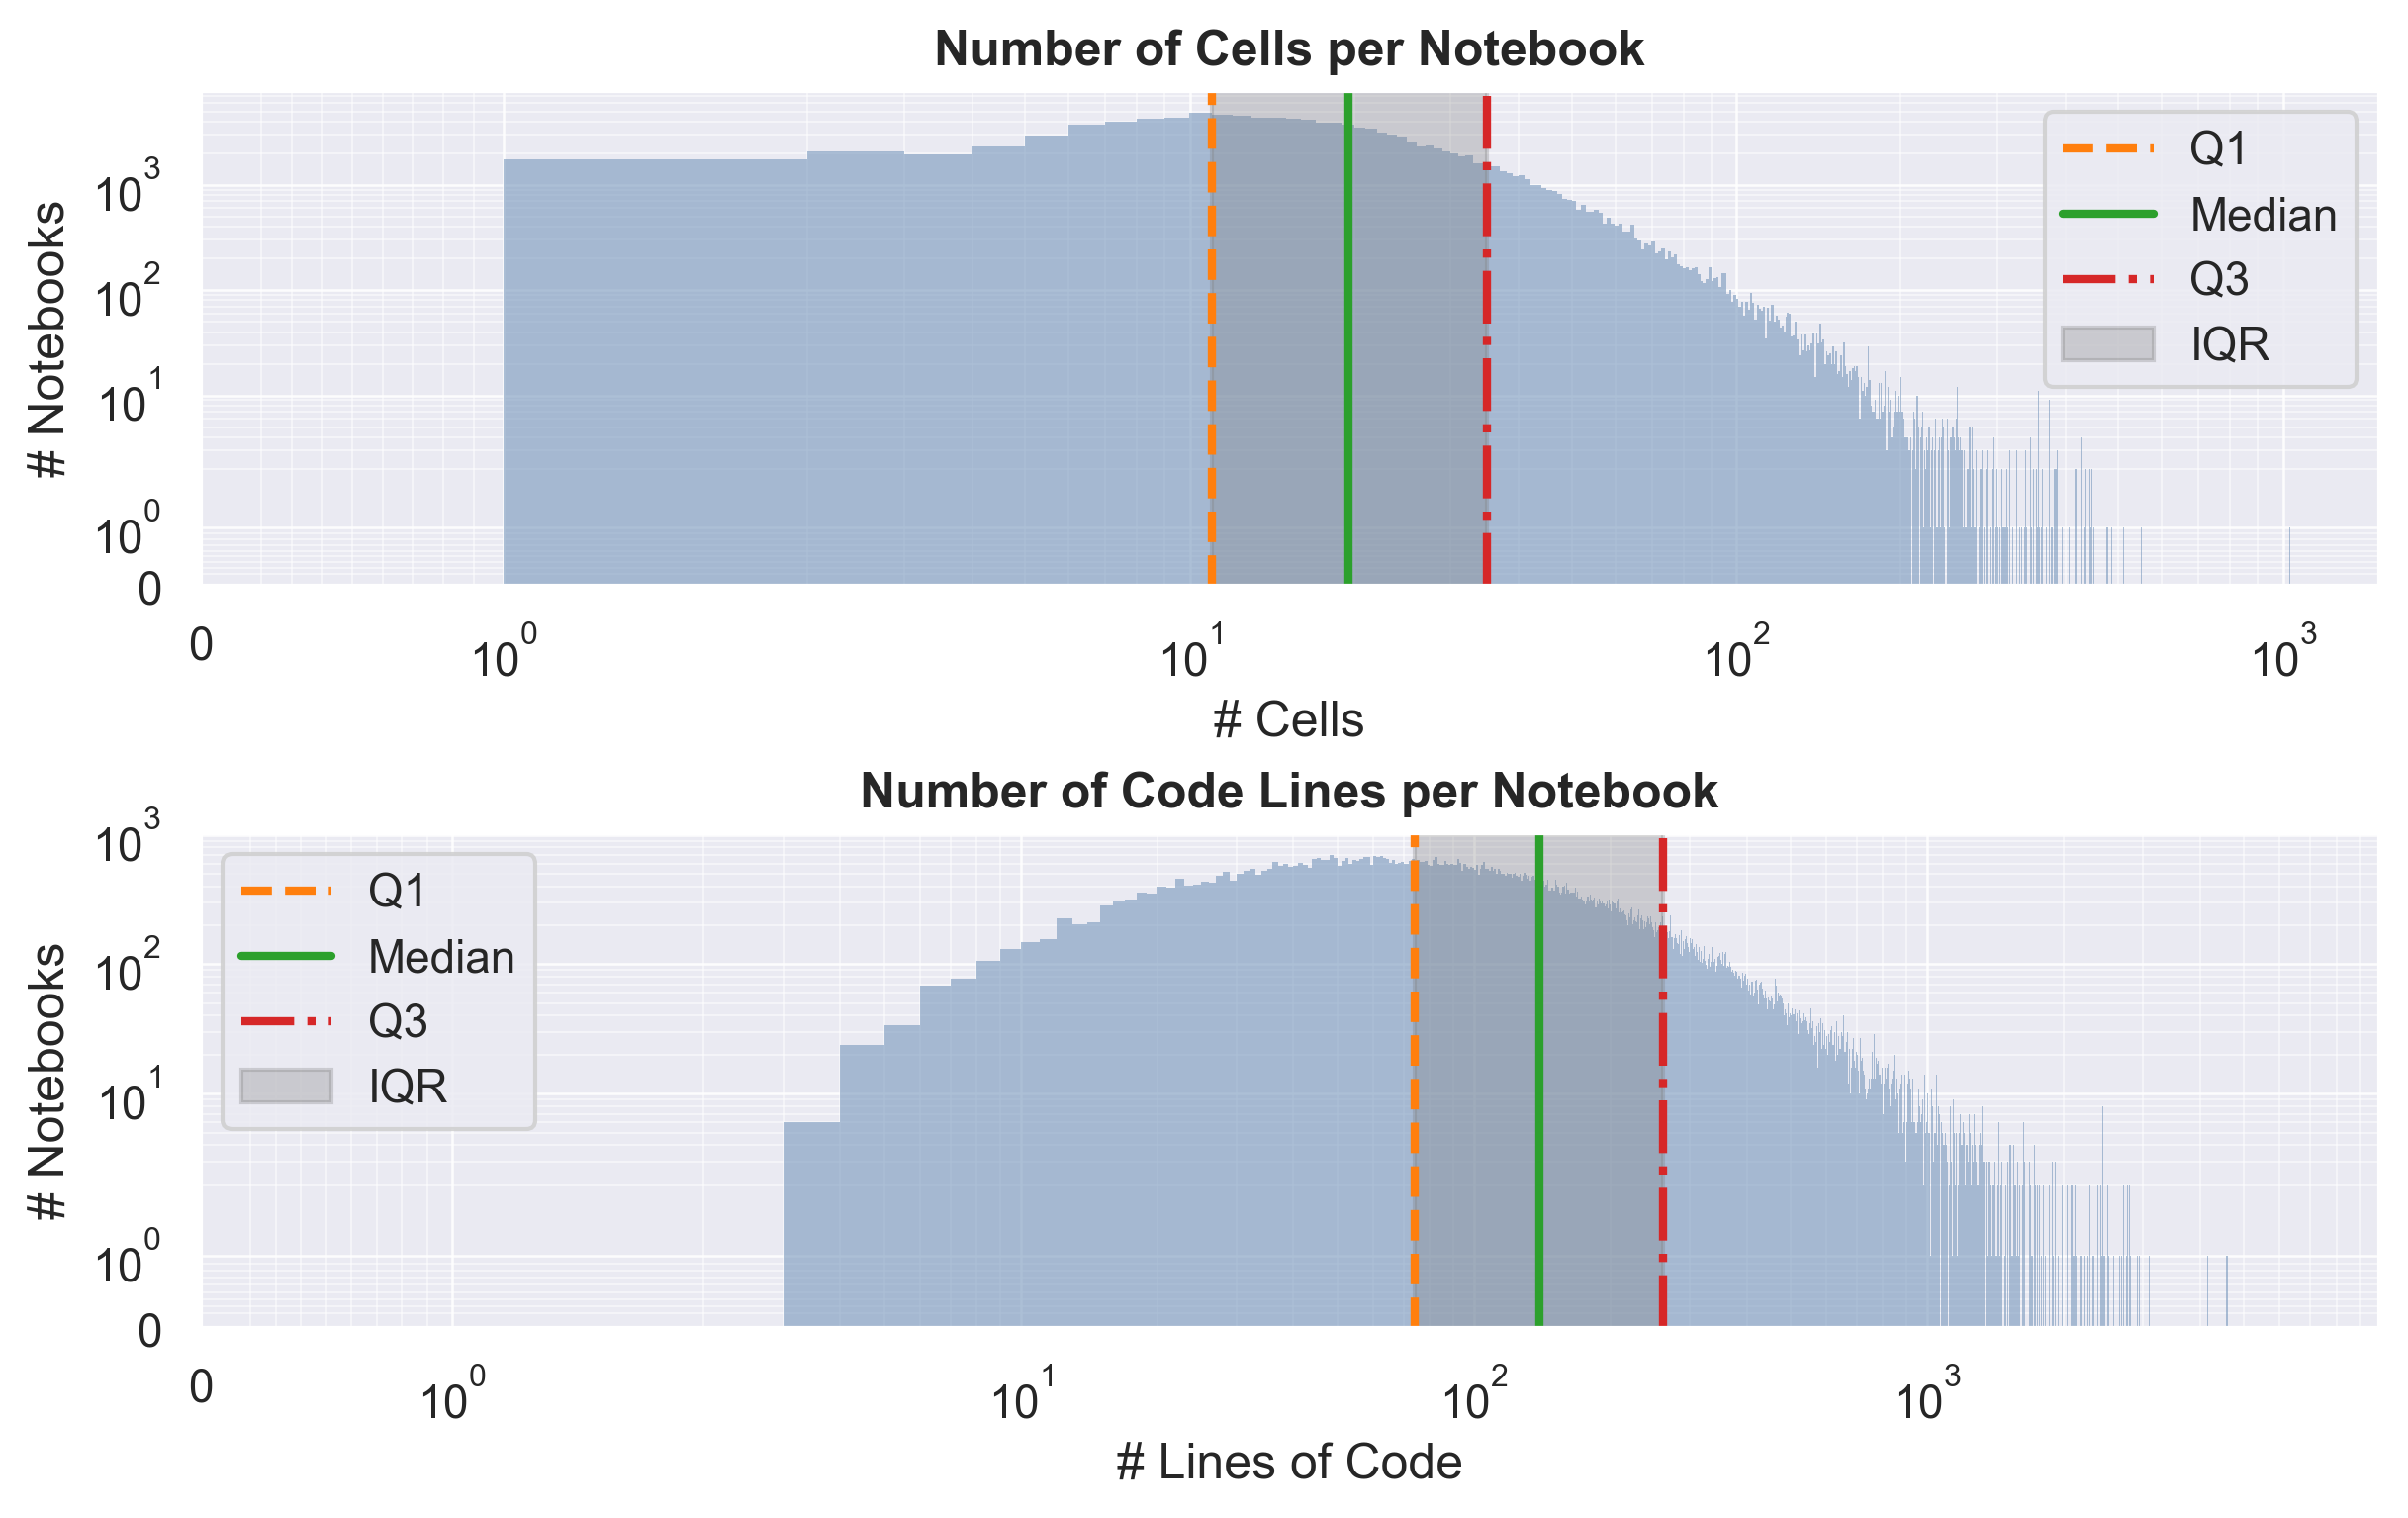

,count,mean,std,min,25%,50%,75%,max
n_cells,139622.0,27.22,28.65,1.0,11.0,19.0,34.0,1030.0
LOC,139622.0,220.92,286.82,3.0,74.0,139.0,260.0,6764.0


In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), constrained_layout=True)

ax_plot_hist(
    ax=axes[0],
    x=nb_df["n_cells"],
    show_outliers=True,
    title='Number of Cells per Notebook',
    xlabel='# Cells',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)
ax_plot_hist(
    ax=axes[1],
    x=nb_df["LOC"],
    title='Number of Code Lines per Notebook',
    xlabel='# Lines of Code',
    ylabel='# Notebooks',
    x_log=True,
    y_log=True
)

plt.show()
nb_stats_df[["n_cells","LOC"]].T

#### Unique number of Repositories

In [ ]:
map_df = pd.read_csv("data/link_hash_map.csv")
map_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139622 entries, 0 to 139621
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   repo_name  139622 non-null  object
 1   repo_url   139622 non-null  object
 2   file_url   139622 non-null  object
 3   hash       139622 non-null  object
dtypes: object(4)
memory usage: 4.3+ MB


In [5]:
map_df["repo_name"].nunique()

99898

#### getting notebook_hash for recreation

In [ ]:
col_name = "TCI"
target_noteboook = cell_df[cell_df[col_name] == cell_df[col_name].max()].iloc[0]
target_noteboook


notebook_hash    a028b1c97200f13b3f4939054f2cc1d1bcfd9851
cell_id                                                15
LOC                                                   618
BLC                                                     0
S                                                     597
P                                                       0
UDF                                                     0
NBD                                                     2
OPRND                                                1711
OPRAT                                                 607
UOPRND                                                 13
UOPRAT                                                  6
ID                                                    122
I                                                       0
PO                                                    584
LCO                                                     2
CO                                                    578
TCO           

In [ ]:
cell_df[cell_df["notebook_hash"] == target_noteboook["notebook_hash"]][["cell_id", col_name]]

#### Pandas Operations

In [ ]:
po_df = pd.read_csv('data/pandas_ops_count.csv')
po_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  136 non-null    object
 1   function  136 non-null    object
 2   count     136 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ KB


In [111]:
po_df.head()

,category,function,count
0,"Reshaping, sorting, transposing",T,51
1,Computations / descriptive stats,abs,21237
2,Reindexing / selection / label manipulation,add_prefix,3537
3,Reindexing / selection / label manipulation,add_suffix,2656
4,"Function application, GroupBy & window",agg,35098


In [112]:
po_df["count"].sum()

np.int64(4012542)

In [26]:
po_df['percentage'] = (po_df['count'] / po_df['count'].sum() * 100).round(2)
po_df = po_df.sort_values('count', ascending=False).reset_index(drop=True)
po_df.head(15)

,category,function,count,percentage
0,Reindexing / selection / label manipulation,head,300877,7.50
1,Computations / descriptive stats,mean,223797,5.58
2,Computations / descriptive stats,sum,202306,5.04
3,"Function application, GroupBy & window",groupby,198799,4.95
4,Reindexing / selection / label manipulation,drop,156530,3.90
5,"Function application, GroupBy & window",apply,144117,3.59
6,conversions,astype,135149,3.37
7,Reindexing / selection / label manipulation,reset_index,132761,3.31
8,Combining / comparing / joining / merging,join,115077,2.87
9,Missing data handling,replace,102480,2.55


In [114]:
po_df.tail(15)

,category,function,count,percentage
121,Combining / comparing / joining / merging,compare,1310,0.03
122,"Reshaping, sorting, transposing",to_xarray,1308,0.03
123,Reindexing / selection / label manipulation,at_time,1285,0.03
124,Time Series-related,first_valid_index,1136,0.03
125,Time Series-related,last_valid_index,822,0.02
126,"Reshaping, sorting, transposing",reorder_levels,762,0.02
127,Data manipulations,wide_to_long,733,0.02
128,Data manipulations,merge_ordered,610,0.02
129,Reindexing / selection / label manipulation,reindex_like,510,0.01
130,Computations / descriptive stats,cummin,490,0.01


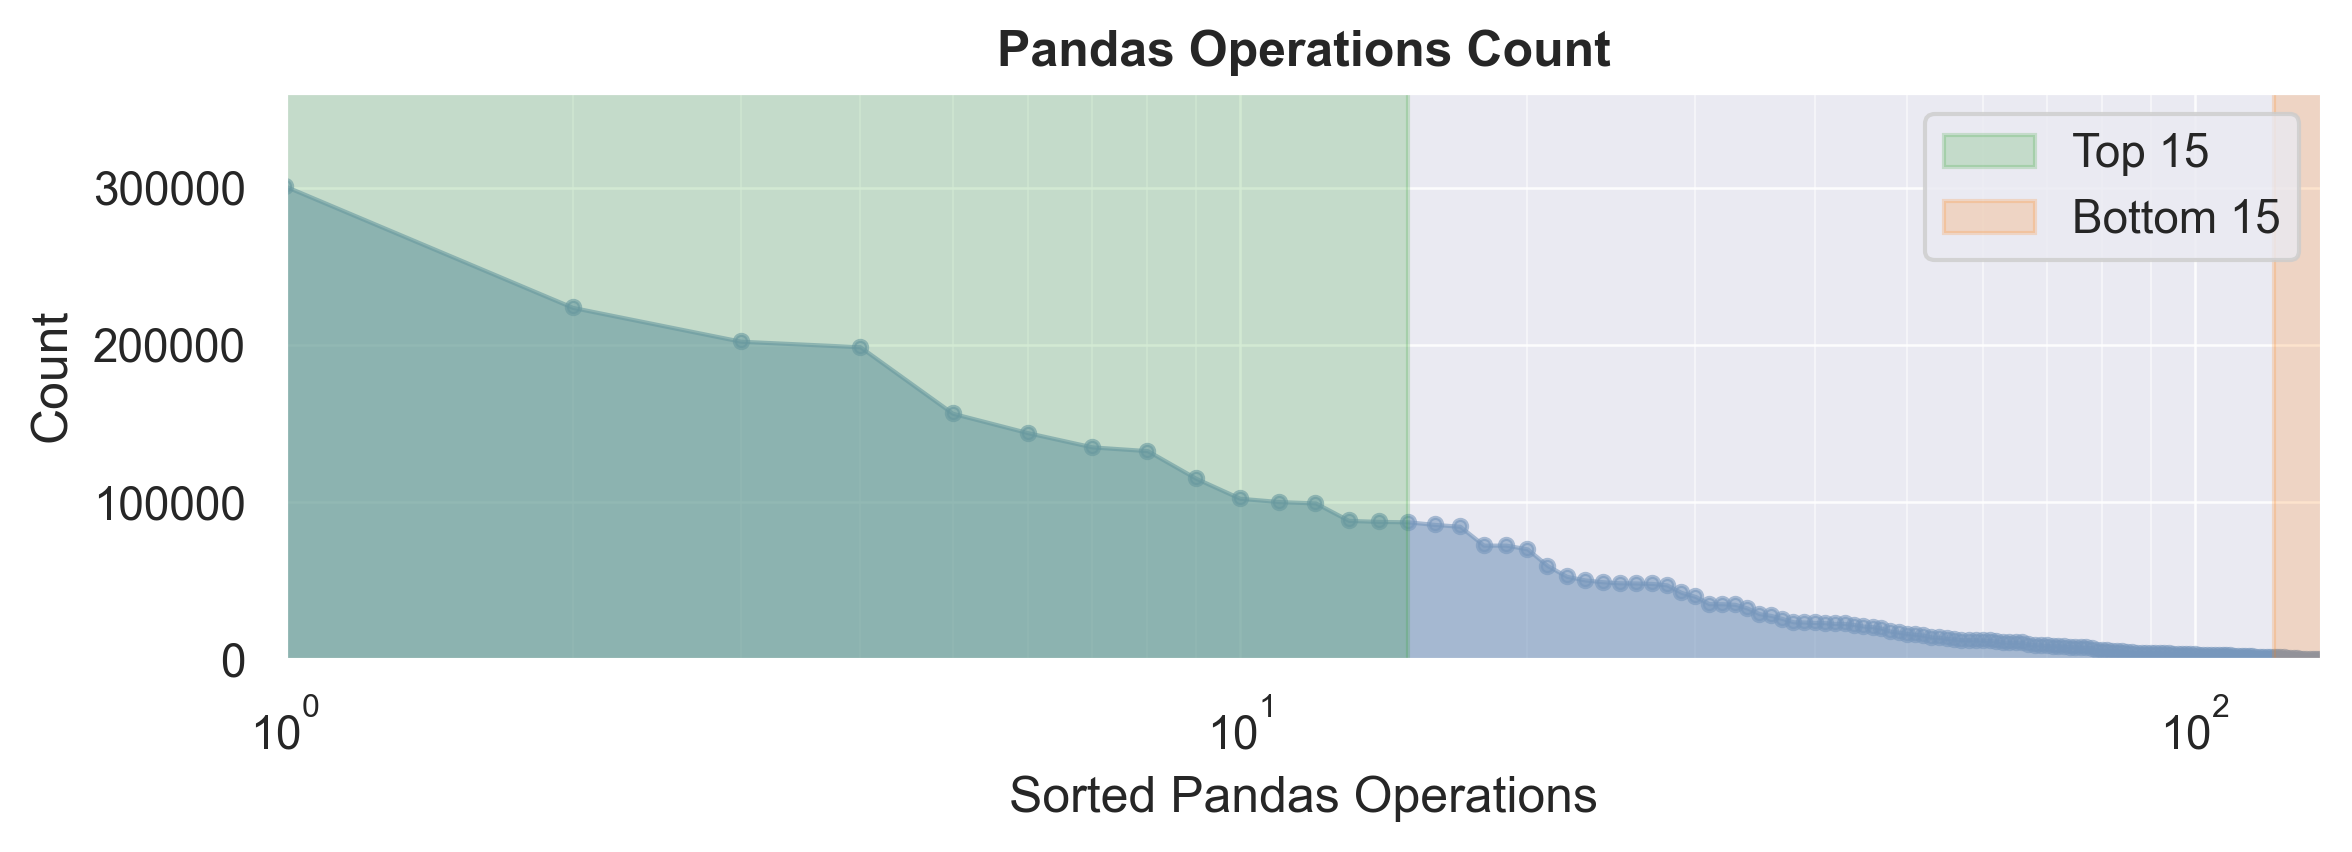

In [27]:
fig, ax = plt.subplots(figsize=(8, 3))

y = po_df["count"]
x = np.arange(y.shape[0]) + 1

ax.fill_between(x, 0, y, color="#7797BC", alpha=0.6)
ax.scatter(x, y, color="#7797BC", alpha=0.6, s=10)

ax.axvspan(1, 15, color='tab:green', alpha=0.2, label='Top 15')
ax.axvspan(x.max()-15, x.max(), color='tab:orange', alpha=0.2, label='Bottom 15')

ax.set_xscale('log')
ax.set_xlim(1, po_df.shape[0])
ax.set_ylim(0, y.max() * 1.2)

ax.set_title("Pandas Operations Count", fontweight='bold')
ax.set_xlabel("Sorted Pandas Operations")
ax.set_ylabel("Count")

ax.grid(True, which="major", alpha=0.9, lw=0.6, ls="-")
ax.grid(True, which="minor", alpha=0.6, lw=0.4, ls="-")
ax.legend()

plt.tight_layout()
plt.show()

#### CSV check

In [ ]:
csvs = pd.read_csv("data/csv_counts.csv")
csvs.shape

(99898, 4)

In [36]:
csvs.head()

,repo_name,repo_url,csv_count,found_at
0,cjporteo/meta-layoffs-analysis,https://github.com/cjporteo/meta-layoffs-analysis,1,2025-09-21T21:16:21Z
1,xiaozhou-alt/text-classifier,https://github.com/xiaozhou-alt/text-classifier,0,2025-09-21T21:16:21Z
2,abishek-bupathi/scikit-learn-basics,https://github.com/abishek-bupathi/scikit-lear...,3,2025-09-21T21:16:21Z
3,PacktPublishing/Hands-On-Feature-Engineering-w...,https://github.com/PacktPublishing/Hands-On-Fe...,4,2025-09-21T21:16:21Z
4,yangk1745/GLP1,https://github.com/yangk1745/GLP1,2,2025-09-21T21:16:21Z


In [37]:
csvc = csvs[csvs["csv_count"] > 0]
csvc = csvc.sort_values("csv_count", ascending=False)
csvc.shape

(62209, 4)

In [38]:
csvc.describe().T

,count,mean,std,min,25%,50%,75%,max
csv_count,62209.0,76.794017,1088.86506,1.0,2.0,5.0,17.0,75024.0


In [20]:
csvc["csv_count"].sum()

np.int64(4777279)

### Code / Markdown cells ratio

In [28]:
code_df = pd.read_csv("source/code_cells.csv", usecols=["notebook_hash", "cell_id"])
md_df = pd.read_csv("source/markdown_cells.csv", usecols=["notebook_hash", "cell_id"])

code_df.shape, md_df.shape

((3800262, 2), (1421726, 2))

In [29]:
code_df["cell_type"] = "code"
md_df["cell_type"] = "text"

df = pd.concat([code_df, md_df], ignore_index=True)
df = df.sort_values(["notebook_hash", "cell_id"])
df.shape

(5221988, 3)

In [30]:
BINS = 100
bins_idx = np.arange(BINS)
text_counts = np.zeros(BINS, dtype=np.int64)
code_counts = np.zeros(BINS, dtype=np.int64)

for nb, g in df.groupby("notebook_hash", sort=False):
    # gets cell types for each cell in the notebook
    types = g["cell_type"].to_numpy()
    N = len(types)
    if N == 0:
        continue

    # mapping notebook bins to 100 bins
    k = (bins_idx * N) // BINS
    chosen = types[k]

    text_counts += (chosen == "text")
    code_counts += (chosen == "code")

total = text_counts + code_counts
text_pct = text_counts / total * 100.0

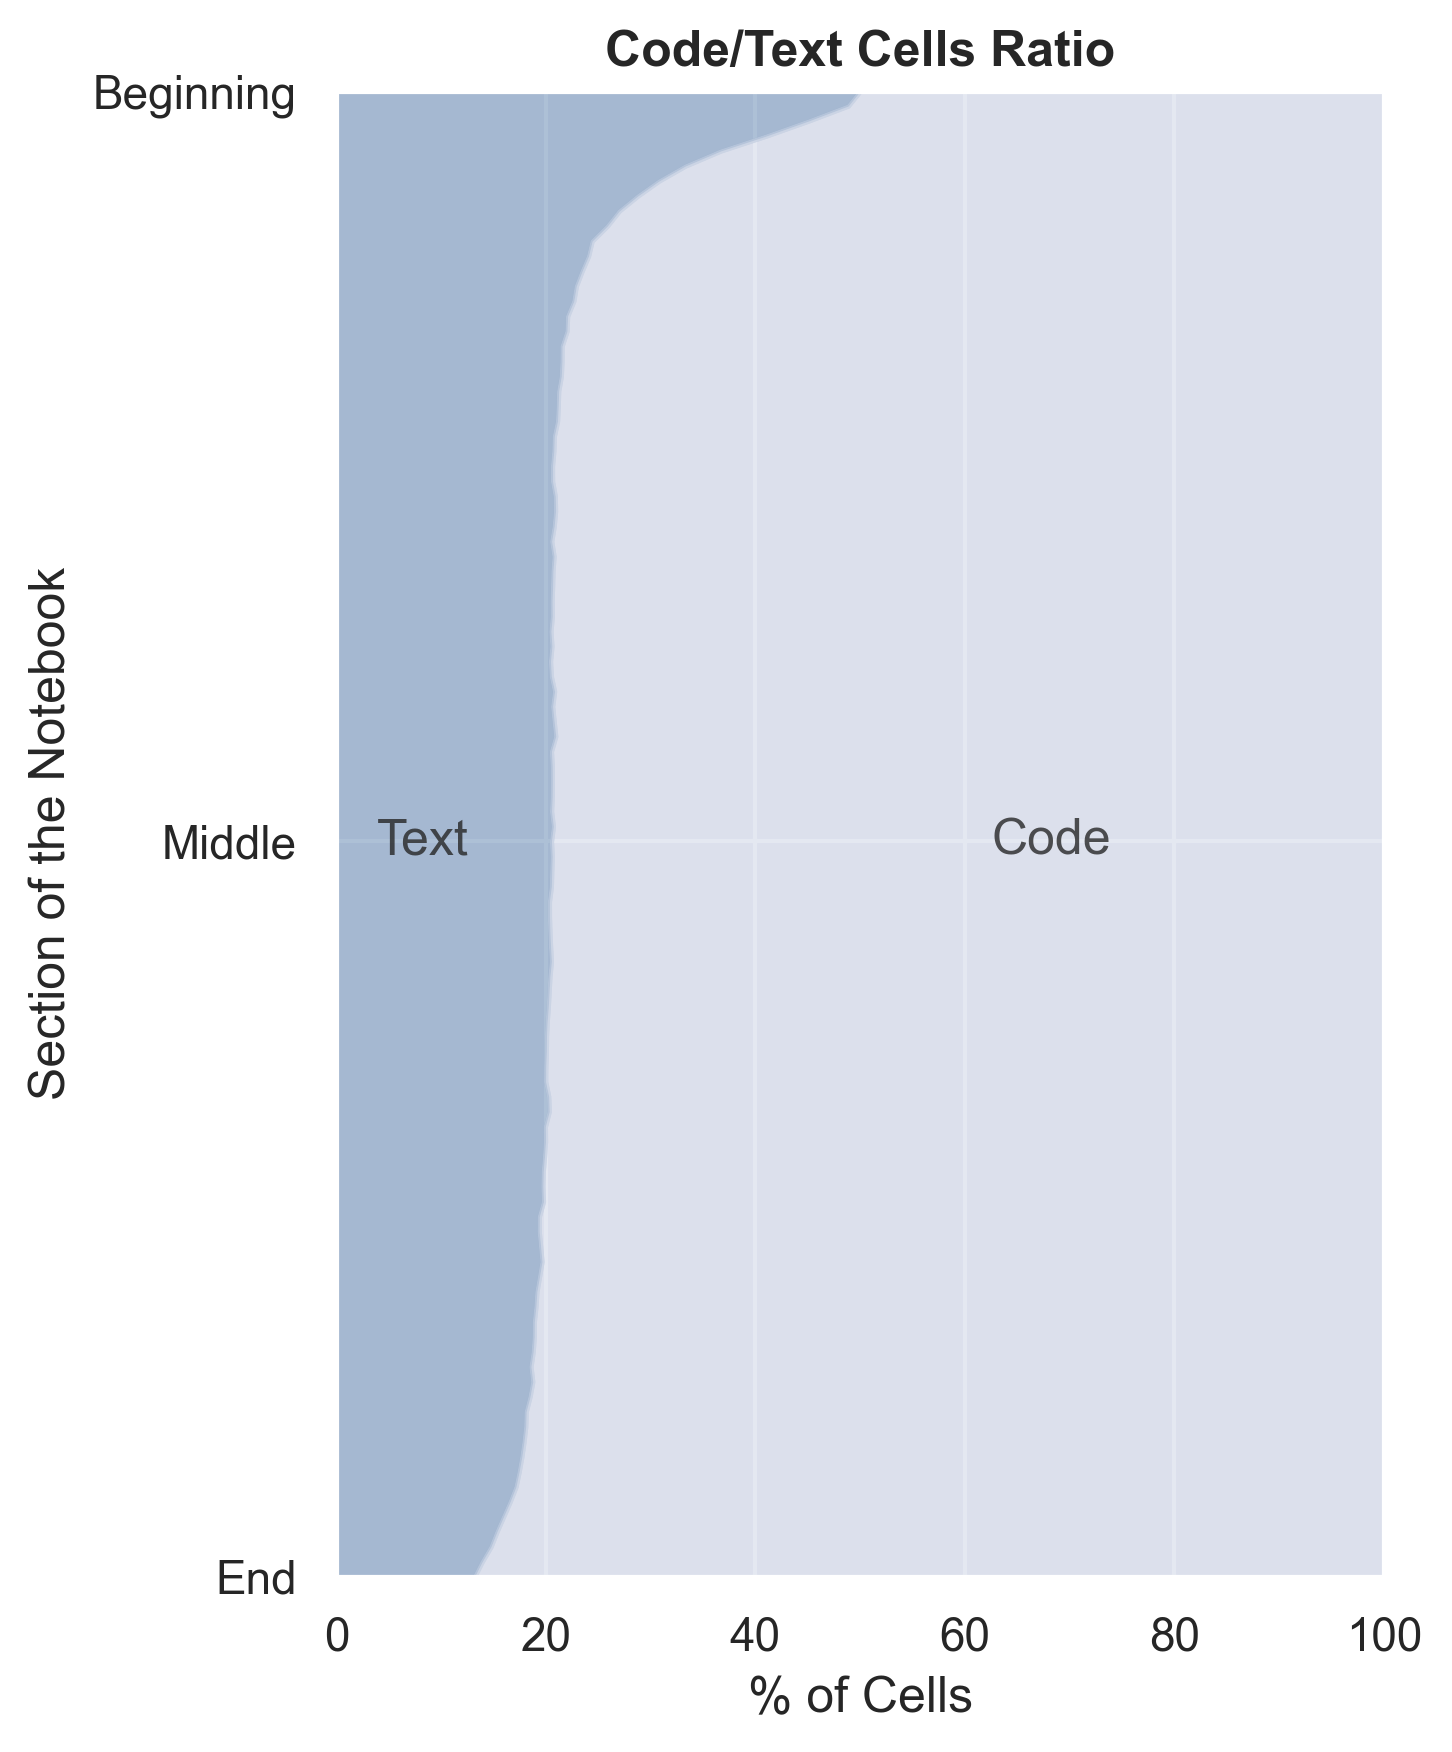

In [31]:
plt.figure(figsize=(5, 6))
plt.fill_betweenx(bins_idx, 0, text_pct, color="#7797BC", alpha=0.6)
plt.fill_betweenx(bins_idx, text_pct, 100, color="#d3dae9", alpha=0.6)

plt.xlim(0, 100)
plt.ylim(99, 0)  # 0 at top

plt.title("Code/Text Cells Ratio", fontweight='bold')
plt.xlabel("% of Cells")
plt.ylabel("Section of the Notebook")
plt.yticks([0, 50, 99], ["Beginning", "Middle", "End"])

# Labels inside the regions
plt.text(max(2, float(np.nanmedian(text_pct)) * 0.4), 50, "Text",
         ha="center", va="center", alpha=0.8)
plt.text(min(98, float(np.nanmedian(text_pct)) + (100 - float(np.nanmedian(text_pct))) * 0.6),
         50, "Code", ha="center", va="center", alpha=0.8)

plt.tight_layout()
plt.show()

### Distributions

In [ ]:
code_df = pd.read_csv("data/code_cells_metrics.csv")
md_df = pd.read_csv("source/markdown_cells.csv")

code_df.shape, md_df.shape

((3800262, 24), (1421726, 3))

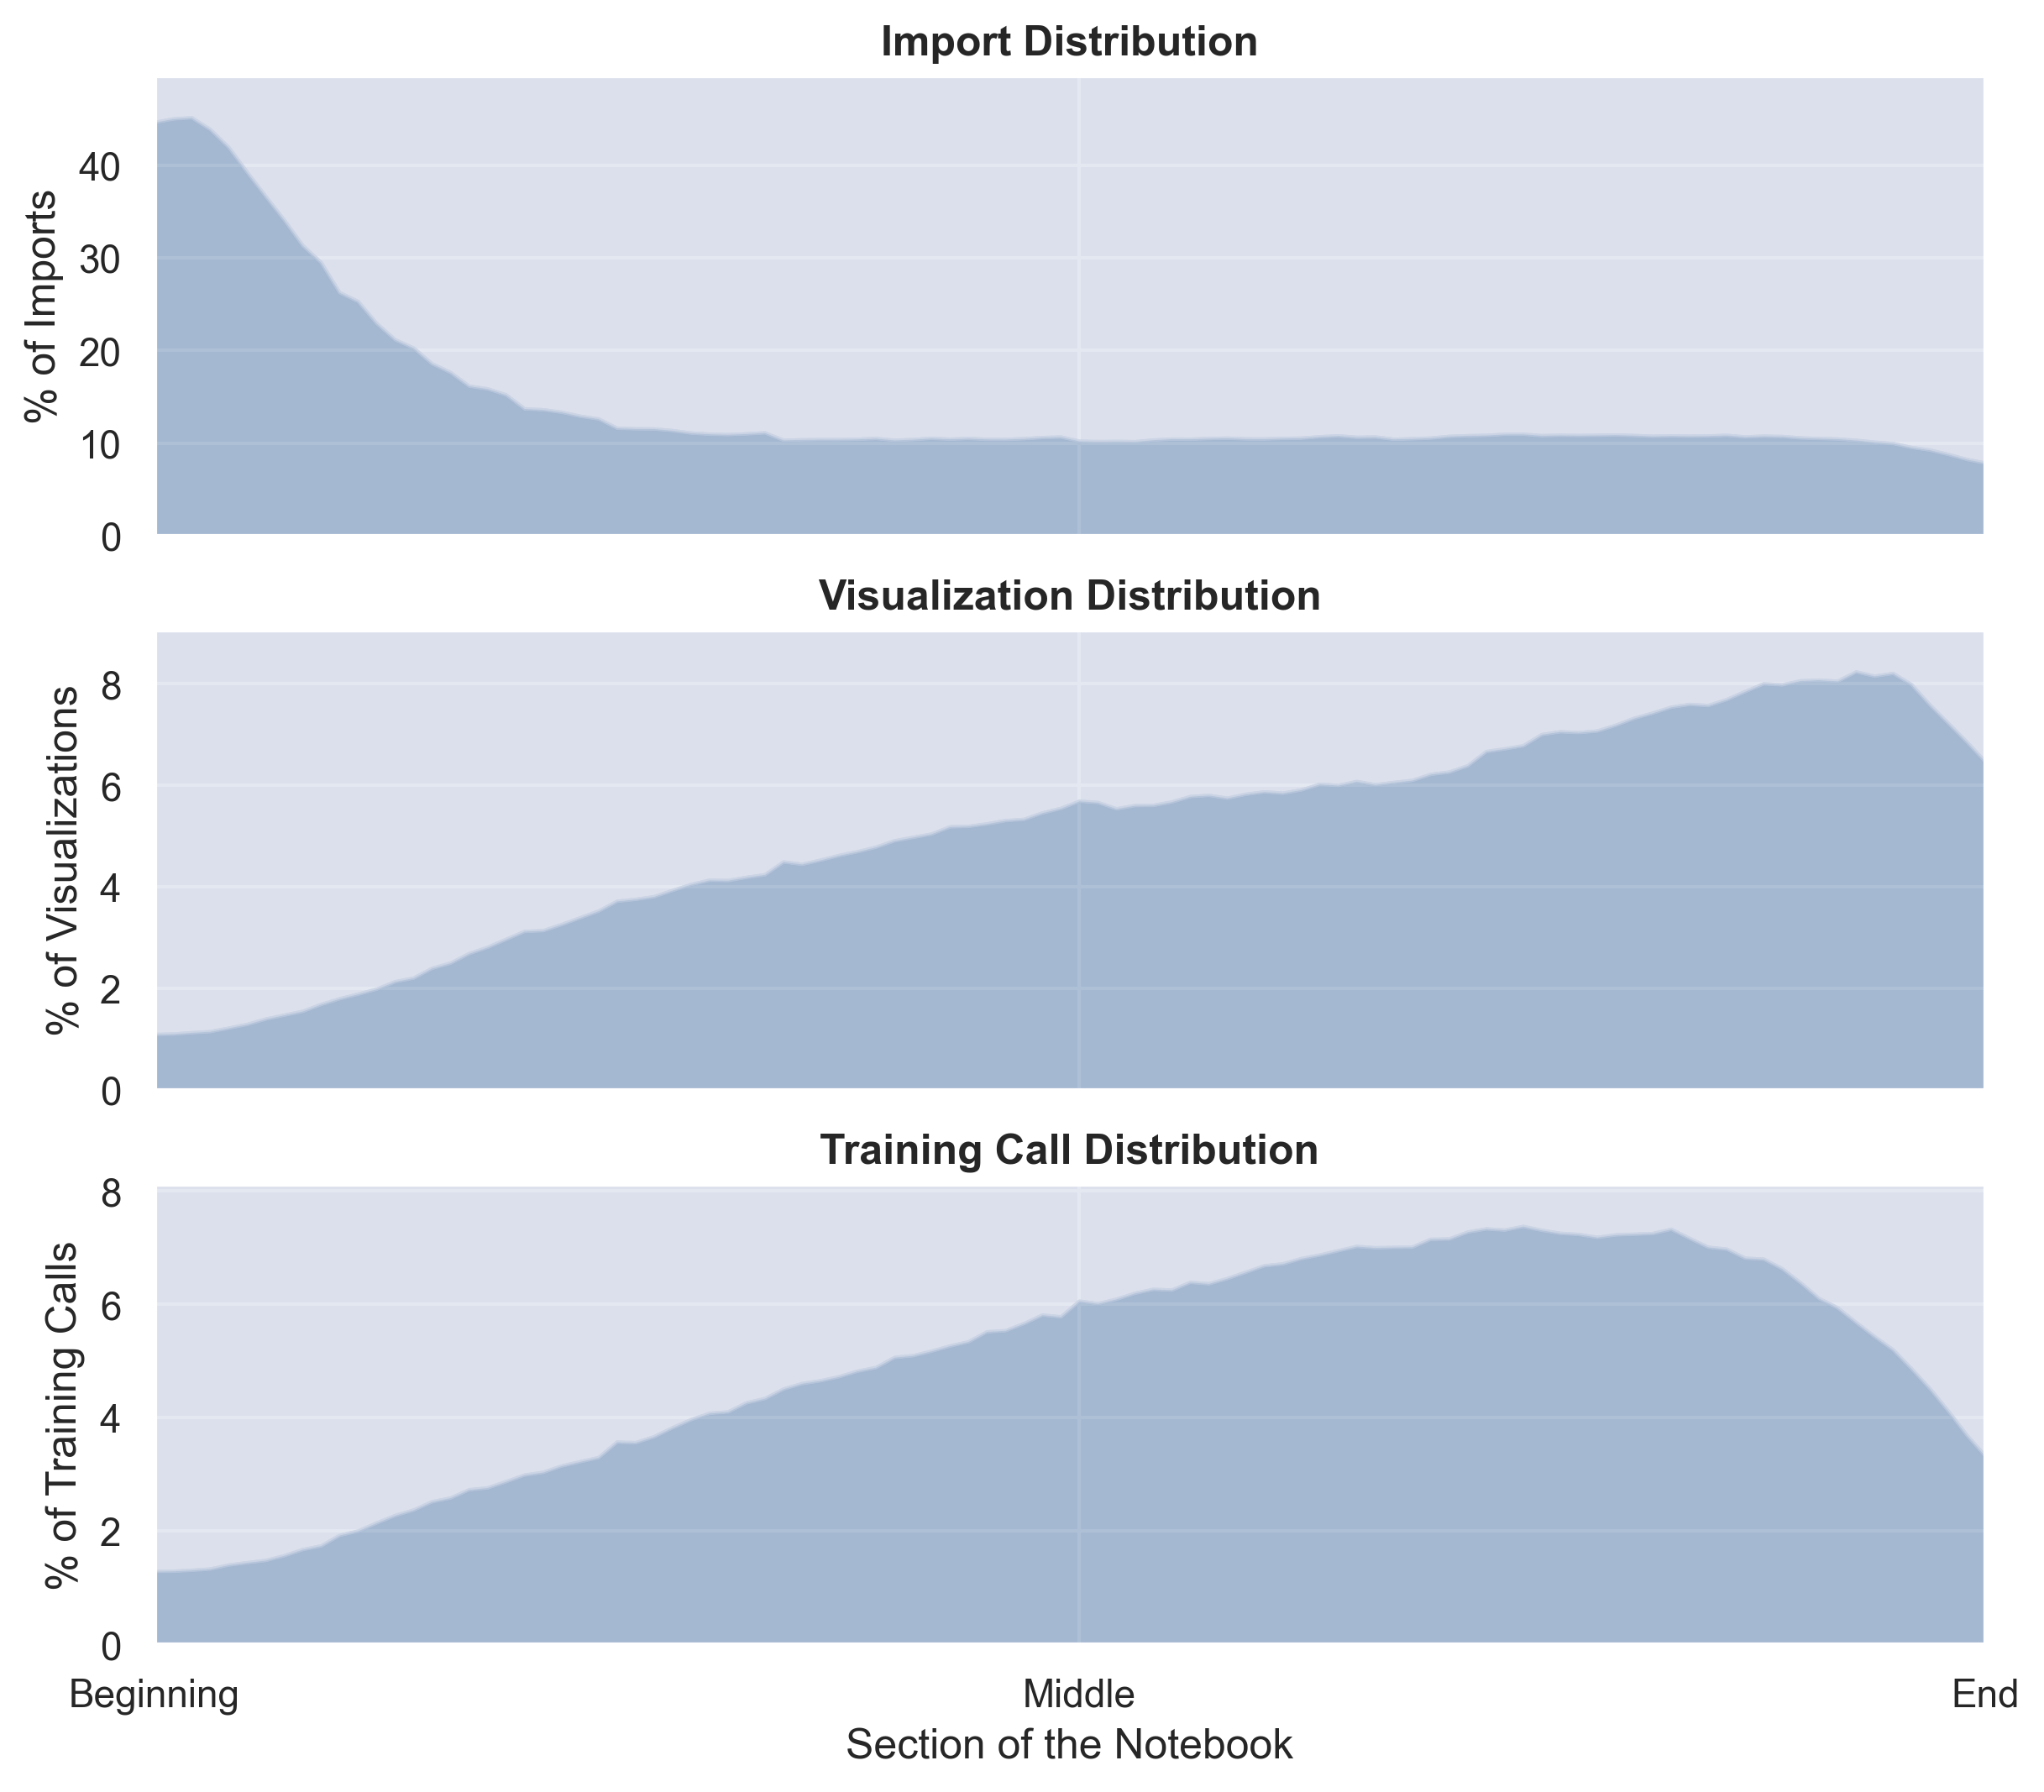

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), constrained_layout=True, sharex=True)

ax_plot_cell_distribution(
    ax=axes[0],
    code_df=code_df,
    md_df=md_df,
    col_name="I",
    title=f"Import Distribution",
    x_label="",
    y_label="% of Imports"
)
ax_plot_cell_distribution(
    ax=axes[1],
    code_df=code_df,
    md_df=md_df,
    col_name="V",
    title=f"Visualization Distribution",
    x_label="",
    y_label="% of Visualizations"
)
ax_plot_cell_distribution(
    ax=axes[2],
    code_df=code_df,
    md_df=md_df,
    col_name="TC",
    title=f"Training Call Distribution",
    y_label="% of Training Calls"
)

plt.show()